In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%%time
df_sessions = pd.read_csv('ga_sessions.csv')
# df_sessions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon_2/ga_sessions.csv')
df_sessions.head(2)

<timed exec>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2.17 s
Wall time: 2.25 s


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow


In [4]:
%%time
df_hits = pd.read_csv('ga_hits.csv')
# df_hits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon_2/ga_hits.csv')
df_hits.head(2)

CPU times: total: 18.3 s
Wall time: 18.4 s


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN


## 1. Исследование и анализ датасета

#### Посмотрим форму датасета `hits`, тип данных, пропуски в данных и содержание датасета

In [7]:
print(f"hits dataset shape: {df_hits.shape}")

hits dataset shape: (15726470, 11)


In [8]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [9]:
missing_values_hits = df_hits.isnull().sum()    # количество пропусков по каждому признаку
total_rows_hits = len(df_hits)                  # общее число строк

# фильтруем только столбцы с пропусками
missing_data_hits = missing_values_hits[missing_values_hits > 0].to_frame(name="Missing Count hits")
missing_data_hits["Missing Percentage hits"] = (missing_data_hits["Missing Count hits"] / total_rows_hits) * 100

missing_data_hits

,Missing Count hits,Missing Percentage hits
hit_time,9160322,58.247795
hit_referer,6274804,39.899634
event_label,3760184,23.909905
event_value,15726470,100.000000


In [10]:
# выведем количество уникальных значений в каждой колонке
for col in df_hits.columns:
    print(f'Количество различных значений в колонке {col}: {df_hits[col].nunique()}')

Количество различных значений в колонке session_id: 1734610
Количество различных значений в колонке hit_date: 226
Количество различных значений в колонке hit_time: 925887
Количество различных значений в колонке hit_number: 500
Количество различных значений в колонке hit_type: 1
Количество различных значений в колонке hit_referer: 37873
Количество различных значений в колонке hit_page_path: 342715
Количество различных значений в колонке event_category: 52
Количество различных значений в колонке event_action: 230
Количество различных значений в колонке event_label: 39825
Количество различных значений в колонке event_value: 0


In [11]:
summary_hits = pd.DataFrame({
    "Missing Count": df_hits.isnull().sum(),
    "Missing Percentage": df_hits.isnull().mean() * 100,
    "Unique Values": df_hits.nunique(),
    "Total Values": df_hits.count()
})

# добавляем процент уникальных от общего количества непустых значений
summary_hits["Unique Percentage"] = (summary_hits["Unique Values"] / summary_hits["Total Values"]) * 100

# округляем проценты до 2 знаков после запятой
summary_hits["Missing Percentage"] = summary_hits["Missing Percentage"].round(2)
summary_hits["Unique Percentage"] = summary_hits["Unique Percentage"].round(2)

summary_hits

,Missing Count,Missing Percentage,Unique Values,Total Values,Unique Percentage
session_id,0,0.00,1734610,15726470,11.03
hit_date,0,0.00,226,15726470,0.00
hit_time,9160322,58.25,925887,6566148,14.10
hit_number,0,0.00,500,15726470,0.00
hit_type,0,0.00,1,15726470,0.00
hit_referer,6274804,39.90,37873,9451666,0.40
hit_page_path,0,0.00,342715,15726470,2.18
event_category,0,0.00,52,15726470,0.00
event_action,0,0.00,230,15726470,0.00
event_label,3760184,23.91,39825,11966286,0.33


#### Посмотрим форму датасета `sessions`, тип данных, пропуски в данных и содержание датасета

In [13]:
print(f"sessions dataset shape: {df_sessions.shape}")

sessions dataset shape: (1860042, 18)


In [14]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [15]:
missing_values_sessions = df_sessions.isnull().sum()    # количество пропусков по каждому признаку
total_rows_sessions = len(df_sessions)                  # общее число строк

# фильтруем только столбцы с пропусками
missing_data_sessions = missing_values_sessions[missing_values_sessions > 0].to_frame(name="Missing Count sessions")
missing_data_sessions["Missing Percentage sessions"] = (missing_data_sessions["Missing Count sessions"] / total_rows_sessions) * 100

missing_data_sessions

,Missing Count sessions,Missing Percentage sessions
utm_source,97,0.005215
utm_campaign,219603,11.806346
utm_adcontent,335615,18.043410
utm_keyword,1082061,58.174009
device_os,1070138,57.533002
device_brand,367178,19.740307
device_model,1843704,99.121633


In [16]:
# выведем количество уникальных значений в каждой колонке
for col in df_sessions.columns:
    print(f'Количество различных значений в колонке {col}: {df_sessions[col].nunique()}')

Количество различных значений в колонке session_id: 1860042
Количество различных значений в колонке client_id: 1391717
Количество различных значений в колонке visit_date: 226
Количество различных значений в колонке visit_time: 85318
Количество различных значений в колонке visit_number: 537
Количество различных значений в колонке utm_source: 293
Количество различных значений в колонке utm_medium: 56
Количество различных значений в колонке utm_campaign: 412
Количество различных значений в колонке utm_adcontent: 286
Количество различных значений в колонке utm_keyword: 1219
Количество различных значений в колонке device_category: 3
Количество различных значений в колонке device_os: 13
Количество различных значений в колонке device_brand: 205
Количество различных значений в колонке device_model: 104
Количество различных значений в колонке device_screen_resolution: 5039
Количество различных значений в колонке device_browser: 57
Количество различных значений в колонке geo_country: 166
Количес

In [17]:
summary_sessions = pd.DataFrame({
    "Missing Count": df_sessions.isnull().sum(),
    "Missing Percentage": df_sessions.isnull().mean() * 100,
    "Unique Values": df_sessions.nunique(),
    "Total Values": df_sessions.count()
})

# добавляем процент уникальных от общего количества непустых значений
summary_sessions["Unique Percentage"] = (summary_sessions["Unique Values"] / summary_sessions["Total Values"]) * 100

# округляем проценты до 2 знаков после запятой
summary_sessions["Missing Percentage"] = summary_sessions["Missing Percentage"].round(2)
summary_sessions["Unique Percentage"] = summary_sessions["Unique Percentage"].round(2)

summary_sessions

,Missing Count,Missing Percentage,Unique Values,Total Values,Unique Percentage
session_id,0,0.00,1860042,1860042,100.00
client_id,0,0.00,1391717,1860042,74.82
visit_date,0,0.00,226,1860042,0.01
visit_time,0,0.00,85318,1860042,4.59
visit_number,0,0.00,537,1860042,0.03
utm_source,97,0.01,293,1859945,0.02
utm_medium,0,0.00,56,1860042,0.00
utm_campaign,219603,11.81,412,1640439,0.03
utm_adcontent,335615,18.04,286,1524427,0.02
utm_keyword,1082061,58.17,1219,777981,0.16


## 2. Предобработка данных

#### Обработаем датасет `sessions`

In [20]:
import pandas as pd

# 1. Удаляем ненужные столбцы
drop_cols = ['client_id', 'device_model', 'device_screen_resolution']
df_sessions = df_sessions.drop(columns=drop_cols)

# 2. Заполняем пропуски в категориальных признаках текстом 'unknown'
fillna_cols = [
    'utm_campaign', 'utm_adcontent', 'utm_keyword',
    'device_os', 'device_brand',
    'utm_source'
]
df_sessions[fillna_cols] = df_sessions[fillna_cols].fillna('unknown')

# 3. Создаем новые признаки из даты визита
# Обработаем колонку "hit_date"
df_sessions['visit_date'] = pd.to_datetime(df_sessions['visit_date'], format="%Y-%m-%d")

# Извлечем в отдельные колонки год, месяц, день, день недели, будний или выходной день
df_sessions['year'] = df_sessions['visit_date'].dt.year
df_sessions['month'] = df_sessions['visit_date'].dt.month
df_sessions['day'] = df_sessions['visit_date'].dt.day
df_sessions['dayofweek'] = df_sessions['visit_date'].dt.day_of_week
df_sessions['is_weekend'] = df_sessions['dayofweek'].isin([5, 6]).astype(int)

# Отдельно обрабатываем время визита
df_sessions['visit_hour'] = pd.to_datetime(df_sessions['visit_time'], format='%H:%M:%S').dt.hour

# После создания новых признаков удаляем старые
df_sessions = df_sessions.drop(columns=['visit_date', 'visit_time'])

# 4. Оставляем только топ-3 браузера, остальные — 'other'
def top_3_browser(df):
    top_browsers = df['device_browser'].value_counts().nlargest(3).index
    df['device_browser'] = df['device_browser'].apply(lambda x: x if x in top_browsers else 'other')
    return df

df_sessions = top_3_browser(df_sessions)

# 5. Оставляем только топ-3 операционных системы, остальные — 'other'
def top_3_device_os(df):
    top_os = df['device_os'].value_counts().nlargest(3).index
    df['device_os'] = df['device_os'].apply(lambda x: x if x in top_os else 'other')
    return df

df_sessions = top_3_device_os(df_sessions)

# 6. Кодируем категориальные признаки через One-Hot Encoding
one_hot_cols = ['device_category', 'device_os', 'device_browser']
df_sessions = pd.get_dummies(df_sessions, columns=one_hot_cols, prefix=one_hot_cols, dtype=int)

# 7. Применяем Top-N кодирование для utm_* полей
def top_n_encode(df, column, top_n=100):
    top_values = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top_values else 'other')
    return df

for col in ['utm_keyword', 'utm_campaign', 'utm_adcontent', 'utm_source', 'utm_medium']:
    df_sessions = top_n_encode(df_sessions, col, top_n=100)

# 8. Кодируем оставшиеся категориальные признаки с помощью OrdinalEncoder
ordinal_encoders = {}
oe_cols = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
           'device_brand', 'geo_country', 'geo_city']

for col in oe_cols:
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df_sessions[[col]] = oe.fit_transform(df_sessions[[col]])

In [21]:
df_sessions.head(2)

,session_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_brand,geo_country,geo_city,...,device_category_mobile,device_category_tablet,device_os_Android,device_os_iOS,device_os_other,device_os_unknown,device_browser_Chrome,device_browser_Safari,device_browser_YaBrowser,device_browser_other
0,9055434745589932991.1637753792.1637753792,1,50.0,6.0,18.0,89.0,83.0,77.0,123.0,2533.0,...,1,0,1,0,0,0,1,0,0,0
1,905544597018549464.1636867290.1636867290,1,24.0,15.0,10.0,96.0,14.0,150.0,123.0,1434.0,...,1,0,1,0,0,0,0,0,0,1


In [22]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   visit_number              int64  
 2   utm_source                float64
 3   utm_medium                float64
 4   utm_campaign              float64
 5   utm_adcontent             float64
 6   utm_keyword               float64
 7   device_brand              float64
 8   geo_country               float64
 9   geo_city                  float64
 10  year                      int32  
 11  month                     int32  
 12  day                       int32  
 13  dayofweek                 int32  
 14  is_weekend                int32  
 15  visit_hour                int32  
 16  device_category_desktop   int32  
 17  device_category_mobile    int32  
 18  device_category_tablet    int32  
 19  device_os_Android         int32  
 20  device_os_iOS           

In [23]:
missing_values_sessions = df_sessions.isnull().sum()    # количество пропусков по каждому признаку
total_rows_sessions = len(df_sessions)                  # общее число строк

# фильтруем только столбцы с пропусками
missing_data_sessions = missing_values_sessions[missing_values_sessions > 0].to_frame(name="Missing Count sessions")
missing_data_sessions["Missing Percentage sessions"] = (missing_data_sessions["Missing Count sessions"] / total_rows_sessions) * 100

missing_data_sessions

,Missing Count sessions,Missing Percentage sessions


#### Выделим из датасета `hits` целевую переменную

Целевые действия хранятся в колонке `event_action`. По условиям задания целевым действием является любое ключевое событие на сайте: Оставить заявку, Заказать звонок, Открыть диалог и др. Сохраним целевые действия в переменную `targets`.

In [26]:
# сохраним целевые действия в переменную targets
targets = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
           'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
           'sub_submit_success', 'sub_car_request_submit_click']

# создадим новый датасет, где в колонке "event_action" останутся только целевые действия
df_targets = df_hits[df_hits['event_action'].isin(targets)]
df_targets.head(2)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
4016,2744563715298057088.1640258436.1640258436,2021-12-23,843092.0,81,event,NaN,sberauto.com/cars/all/kia/rio/fee33fe6?utm_sou...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
4045,3087297479839089634.1640268774.1640268774,2021-12-23,194144.0,22,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?utm...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN


In [27]:
df_targets['event_action'].value_counts()

event_action
sub_car_claim_click                 37928
sub_open_dialog_click               25870
sub_submit_success                  18439
sub_car_claim_submit_click          12359
sub_call_number_click                3653
sub_callback_submit_click            3074
sub_car_request_submit_click         2966
sub_custom_question_submit_click      619
Name: count, dtype: int64

#### Добавим в датасет `sessions` целевую переменную и далее будем работать с этим датасетом

In [29]:
df_sessions['y'] = df_sessions['session_id'].isin(df_targets['session_id']).astype(int)

oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_sessions['session_id'] = oe.fit_transform(df_sessions['session_id'].values.reshape(-1, 1))

df_sessions.head(2)

,session_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_brand,geo_country,geo_city,...,device_category_tablet,device_os_Android,device_os_iOS,device_os_other,device_os_unknown,device_browser_Chrome,device_browser_Safari,device_browser_YaBrowser,device_browser_other,y
0,1804430.0,1,50.0,6.0,18.0,89.0,83.0,77.0,123.0,2533.0,...,0,1,0,0,0,1,0,0,0,0
1,1804431.0,1,24.0,15.0,10.0,96.0,14.0,150.0,123.0,1434.0,...,0,1,0,0,0,0,0,0,1,0


In [30]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                float64
 1   visit_number              int64  
 2   utm_source                float64
 3   utm_medium                float64
 4   utm_campaign              float64
 5   utm_adcontent             float64
 6   utm_keyword               float64
 7   device_brand              float64
 8   geo_country               float64
 9   geo_city                  float64
 10  year                      int32  
 11  month                     int32  
 12  day                       int32  
 13  dayofweek                 int32  
 14  is_weekend                int32  
 15  visit_hour                int32  
 16  device_category_desktop   int32  
 17  device_category_mobile    int32  
 18  device_category_tablet    int32  
 19  device_os_Android         int32  
 20  device_os_iOS           

In [31]:
missing_values_sessions = df_sessions.isnull().sum()    # количество пропусков по каждому признаку
total_rows_sessions = len(df_sessions)                  # общее число строк

# фильтруем только столбцы с пропусками
missing_data_sessions = missing_values_sessions[missing_values_sessions > 0].to_frame(name="Missing Count df_sessions")
missing_data_sessions["Missing Percentage df_sessions"] = (missing_data_sessions["Missing Count df_sessions"] / total_rows_sessions) * 100

missing_data_sessions

,Missing Count df_sessions,Missing Percentage df_sessions


## 3. Разведочный анализ (EDA)

In [33]:
all_unique = df_sessions['session_id'].nunique()
print(f'Все значения колонки `sessions_id` уникальны: {all_unique}')

Все значения колонки `sessions_id` уникальны: 1860042


In [34]:
df_sessions['visit_number'] = pd.to_datetime(df_sessions['visit_number']) # переведем данные столбца в формат даты
n_unique = df_sessions['visit_number'].nunique()
print(f'Количество уникальных значений в `visit_number`: {n_unique}')

Количество уникальных значений в `visit_number`: 537


##Построения диаграммы рассеяния

Типы данных в датасете:
visit_number    datetime64[ns]
visit_hour               int32
dtype: object


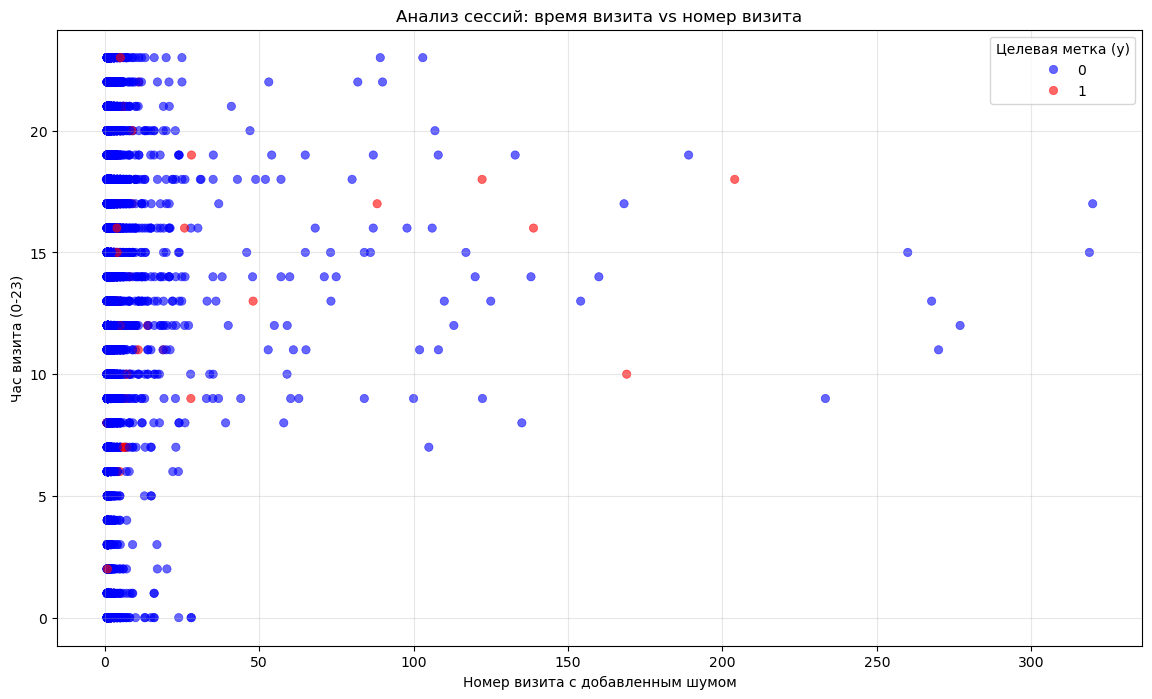

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Проверка типов данных
print("Типы данных в датасете:")
print(df_sessions[['visit_number', 'visit_hour']].dtypes)

# Фикс типов данных (если необходимо)
df_sessions['visit_number'] = df_sessions['visit_number'].astype('int64')
df_sessions['visit_hour'] = df_sessions['visit_hour'].astype('int64')

# Создание подвыборки
sample_df = df_sessions.sample(n=10000, random_state=42)

# Добавление шума только к числовым данным
sample_df['visit_number_jitter'] = sample_df['visit_number'].astype(float) + np.random.normal(0, 0.1, size=len(sample_df))

# Построение графика
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=sample_df,
    x='visit_number_jitter',
    y='visit_hour',
    hue='y',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    edgecolor=None
)
plt.title('Анализ сессий: время визита vs номер визита')
plt.xlabel('Номер визита с добавленным шумом')
plt.ylabel('Час визита (0-23)')
plt.grid(True, alpha=0.3)
plt.legend(title='Целевая метка (y)')
plt.show()

##Построение гистограммы распределения признаков

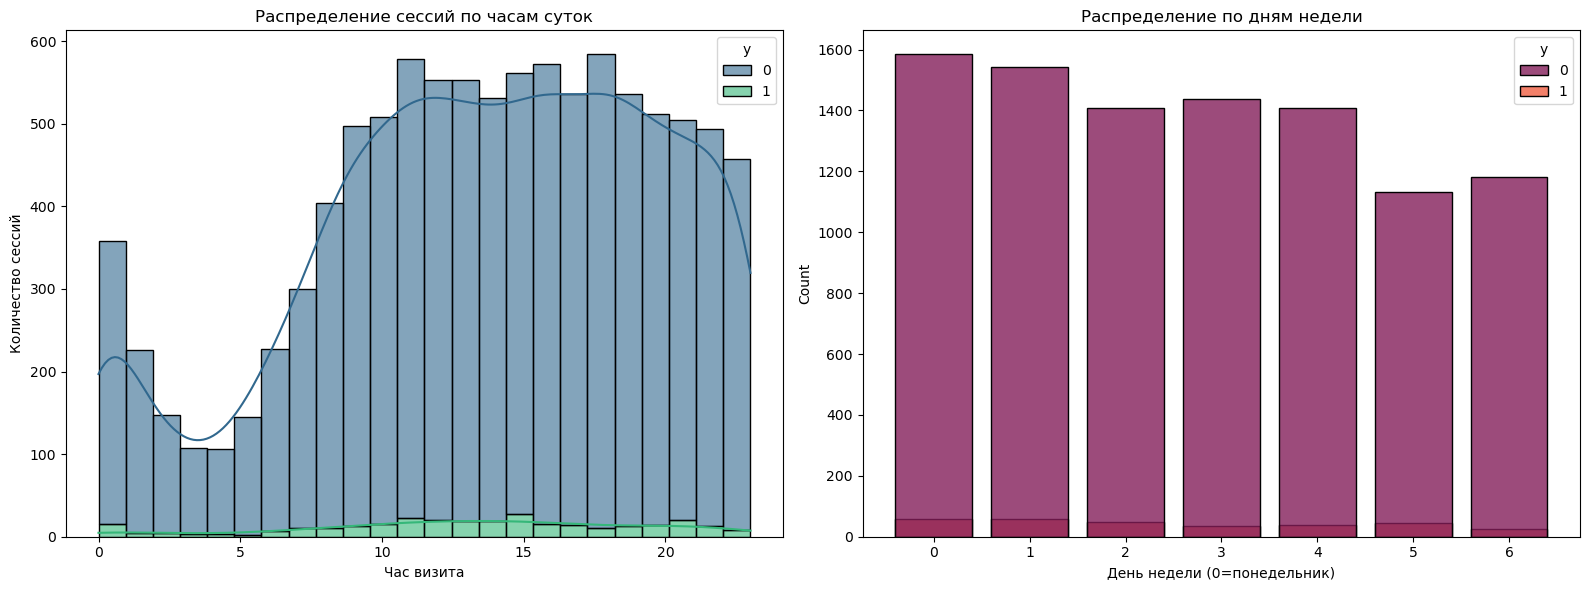

In [38]:
plt.figure(figsize=(16, 6))

# Гистограмма распределения сессий по часам с разделением по классам
plt.subplot(1, 2, 1)
sns.histplot(
    data=sample_df,
    x='visit_hour',
    hue='y',
    bins=24,
    kde=True,
    palette='viridis',
    alpha=0.6,
    multiple='stack'
)
plt.title('Распределение сессий по часам суток')
plt.xlabel('Час визита')
plt.ylabel('Количество сессий')

# Гистограмма распределения по дням недели
plt.subplot(1, 2, 2)
sns.histplot(
    data=sample_df,
    x='dayofweek',
    hue='y',
    bins=7,
    discrete=True,
    palette='rocket',
    alpha=0.8,
    shrink=0.8
)
plt.title('Распределение по дням недели')
plt.xlabel('День недели (0=понедельник)')
plt.xticks(ticks=[0,1,2,3,4,5,6])

plt.tight_layout()
plt.show()

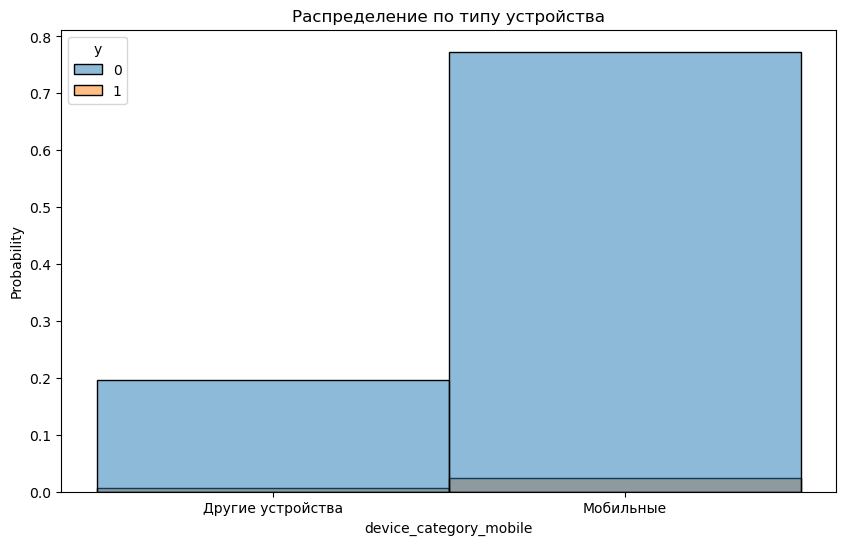

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=sample_df,
    x='device_category_mobile',
    hue='y',
    stat='probability',
    bins=3,
    discrete=True
)
plt.title('Распределение по типу устройства')
plt.xticks([0,1], ['Другие устройства', 'Мобильные'])
plt.show()

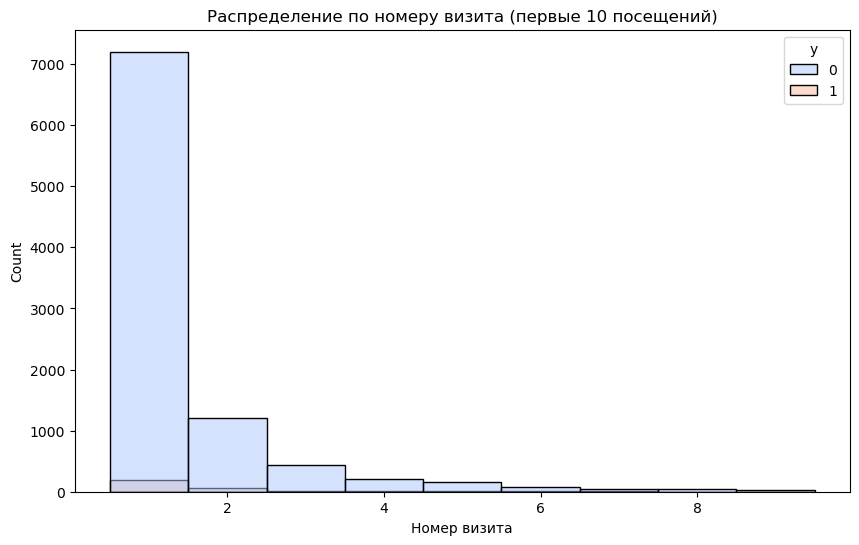

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=sample_df[sample_df['visit_number'] < 10], # Фильтр для первых 10 визитов
    x='visit_number',
    hue='y',
    bins=9,
    discrete=True,
    palette='coolwarm'
)
plt.title('Распределение по номеру визита (первые 10 посещений)')
plt.xlabel('Номер визита')
plt.show()

##Анализ ключевых числовых признаков, временных характеристик и поведенческих метрик.


C:\Users\Roman\AppData\Local\Temp\ipykernel_28516\3350057095.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Roman\AppData\Local\Temp\ipykernel_28516\3350057095.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


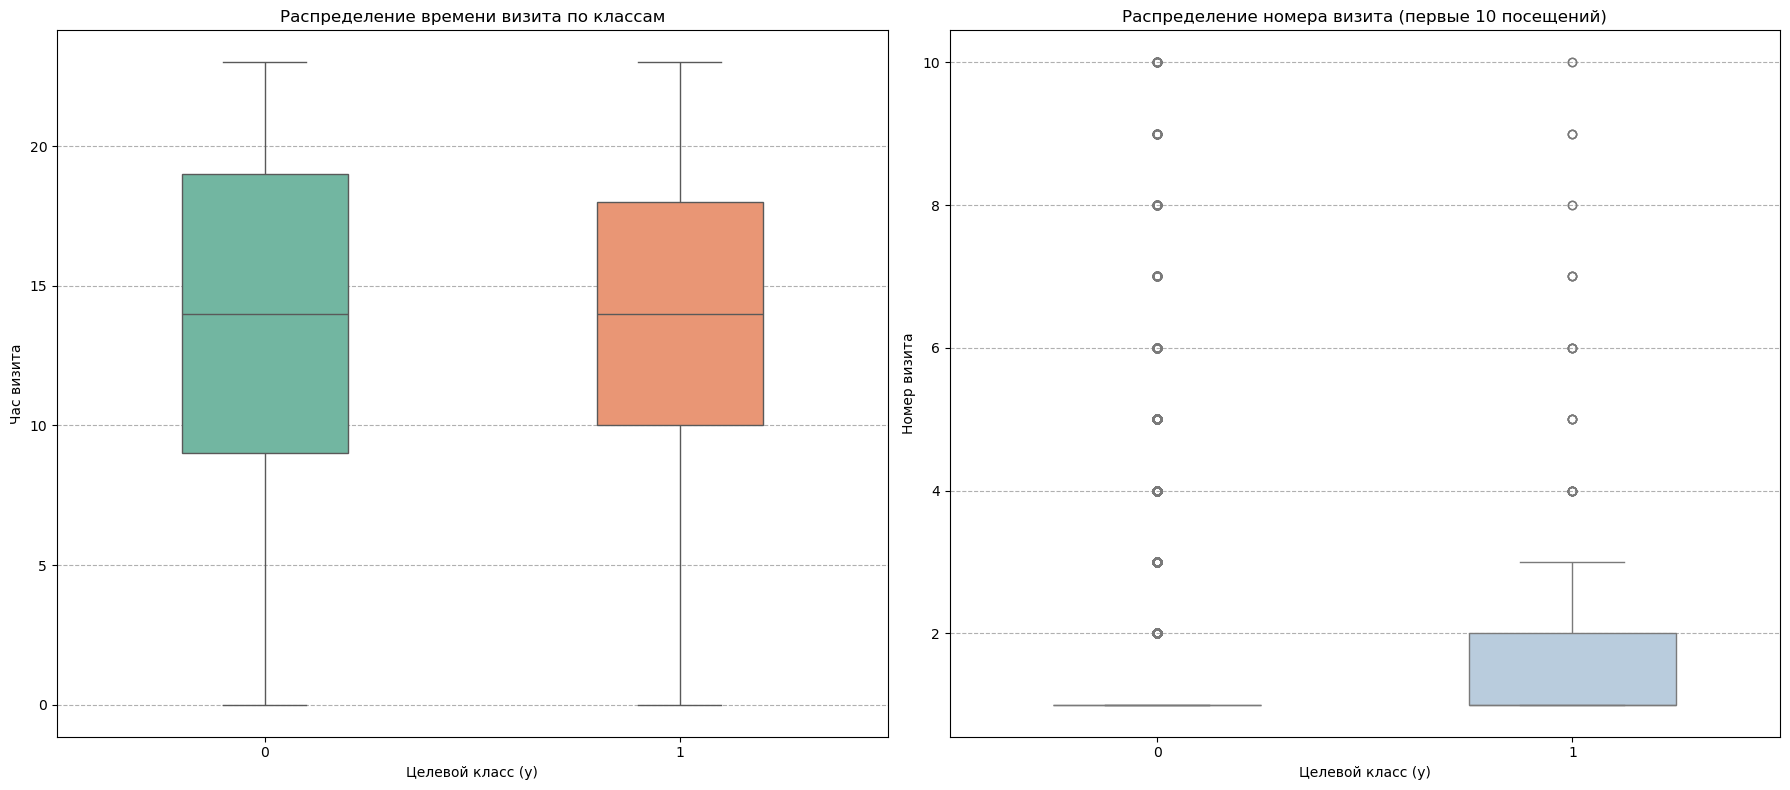

In [42]:
plt.figure(figsize=(18, 8))

# Box plot для времени визита (visit_hour)
plt.subplot(1, 2, 1)
sns.boxplot(
    data=sample_df,
    x='y',
    y='visit_hour',
    palette='Set2',
    width=0.4,
    showfliers=False  # Исключаем выбросы для наглядности
)
plt.title('Распределение времени визита по классам')
plt.xlabel('Целевой класс (y)')
plt.ylabel('Час визита')
plt.grid(axis='y', linestyle='--')

# Box plot для номера визита (visit_number)
plt.subplot(1, 2, 2)
sns.boxplot(
    data=sample_df[sample_df['visit_number'] <= 10],  # Фильтр для первых 10 визитов
    x='y',
    y='visit_number',
    palette='Pastel1',
    width=0.5
)
plt.title('Распределение номера визита (первые 10 посещений)')
plt.xlabel('Целевой класс (y)')
plt.ylabel('Номер визита')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

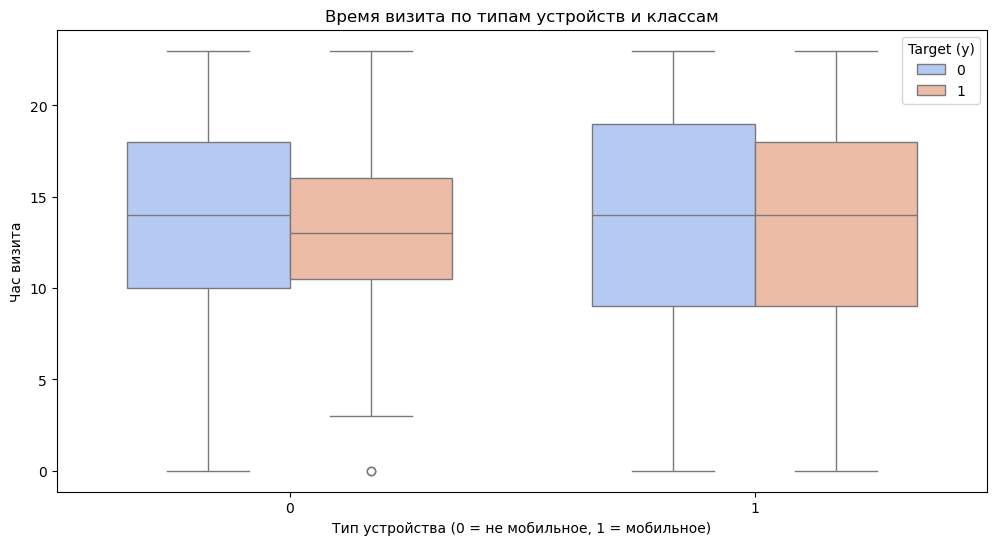

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=sample_df,
    x='device_category_mobile',
    y='visit_hour',
    hue='y',
    palette='coolwarm',
    width=0.7
)
plt.title('Время визита по типам устройств и классам')
plt.xlabel('Тип устройства (0 = не мобильное, 1 = мобильное)')
plt.ylabel('Час визита')
plt.legend(title='Target (y)')
plt.show()

##Статистический анализ

In [45]:
# Анализ для числовых признаков
numeric_features = ['visit_number', 'visit_hour', 'utm_source', 'utm_campaign']
stats_numeric = sample_df[numeric_features].agg(['mean', 'median']).T
stats_numeric['mode'] = sample_df[numeric_features].mode().iloc[0].values

# Анализ для категориальных признаков
categorical_features = ['device_category_mobile', 'geo_country', 'device_os_Android']
stats_categorical = sample_df[categorical_features].agg(['mean', 'median', lambda x: x.mode()[0]]).T
stats_categorical.columns = ['mean', 'median', 'mode']

# Объединение результатов
combined_stats = pd.concat([stats_numeric, stats_categorical])
print(combined_stats.round(2))

                          mean  median   mode
visit_number              2.64     1.0    1.0
visit_hour               13.55    14.0   18.0
utm_source               51.01    50.0   50.0
utm_campaign             38.28    19.0   19.0
device_category_mobile    0.80     1.0    1.0
geo_country             122.53   123.0  123.0
device_os_Android         0.26     0.0    0.0


Средний номер визита выше медианы (1.0), что указывает на правостороннюю асимметрию, большинство сессий — первые визиты. Половина визитов происходит до 14:00. Пиковый час активности — 18:00. 80% сессий с мобильных устройств.
Мобильные устройства — самый частый тип

In [47]:
# Группировка по целевой переменной
class_comparison = sample_df.groupby('y')[numeric_features + categorical_features].agg({
    'visit_number': ['mean', 'median'],
    'visit_hour': ['mean', lambda x: x.mode()[0]],
    'device_category_mobile': 'mean'
})

# Переименование колонок
class_comparison.columns = ['VisitNum_Mean', 'VisitNum_Median',
                           'VisitHour_Mean', 'VisitHour_Mode',
                           'Mobile_Usage_Rate']
print(class_comparison.round(2))

   VisitNum_Mean  VisitNum_Median  VisitHour_Mean  VisitHour_Mode  \
y                                                                   
0           2.57              1.0           13.56              18   
1           4.73              1.0           13.18              15   

   Mobile_Usage_Rate  
y                     
0               0.80  
1               0.78  


Анализ признака страна.

In [49]:
# Проверка типа данных и пропусков
print(f"Тип данных geo_country: {df_sessions['geo_country'].dtype}")
print(f"Пропуски: {df_sessions['geo_country'].isna().sum()}")

Тип данных geo_country: float64
Пропуски: 0


In [50]:
df_sessions['geo_country'].value_counts(dropna=False).head(10)

geo_country
123.0    1800565
157.0      11784
154.0       9012
69.0        4034
16.0        3636
142.0       2694
74.0        2279
52.0        2232
151.0       1953
102.0       1549
Name: count, dtype: int64

In [51]:
# # Пример для графика
# plt.figure(figsize=(12, 6))
# sns.barplot(
#     x=top_countries.index.astype(str),  # Преобразуем коды в строки
#     y=top_countries.values,
#     palette="Blues"
# )
# plt.title("Топ стран (код 123.0 = Основной рынок)")
# plt.xlabel("Код страны")
# plt.ylabel("Количество сессий")
# plt.show()

In [52]:
top_countries = df_sessions['geo_country'].value_counts().head(10).index.tolist()

In [53]:
# Получаем топ-10 стран по количеству сессий
top_countries = df_sessions['geo_country'].value_counts().head(10).index.tolist()

# Рассчитываем статистику конверсии
conversion_stats = (
    df_sessions[df_sessions['geo_country'].isin(top_countries)]
    .groupby('geo_country')
    .agg(
        total_sessions=('y', 'count'),
        conversions=('y', 'sum')
    )
    .reset_index()
)

# Добавляем столбец с процентом конверсии
conversion_stats['conversion_rate'] = (conversion_stats['conversions'] / conversion_stats['total_sessions']) * 100

# Выводим результат
print(conversion_stats.round(2))  # Округляем до двух знаков после запятой

   geo_country  total_sessions  conversions  conversion_rate
0         16.0            3636           59             1.62
1         52.0            2232           78             3.49
2         69.0            4034            1             0.02
3         74.0            2279           54             2.37
4        102.0            1549           38             2.45
5        123.0         1800565        49156             2.73
6        142.0            2694           26             0.97
7        151.0            1953           48             2.46
8        154.0            9012          199             2.21
9        157.0           11784           64             0.54


C:\Users\Roman\AppData\Local\Temp\ipykernel_28516\1966927325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


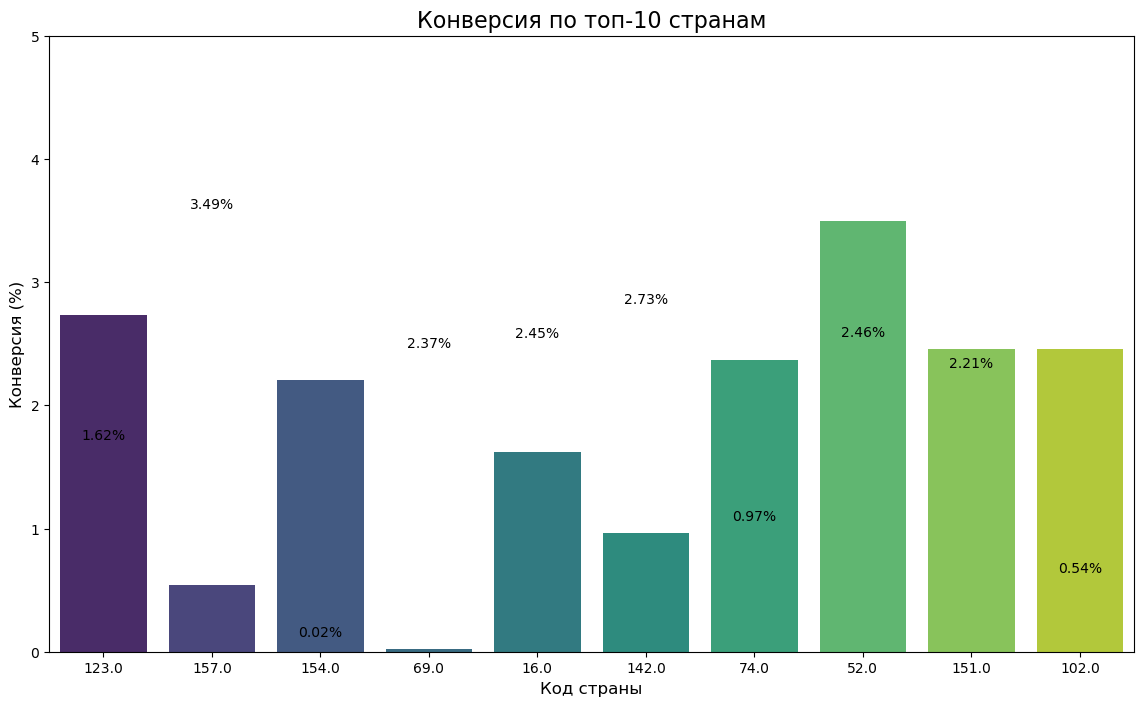

In [54]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=conversion_stats,
    x='geo_country',
    y='conversion_rate',
    palette='viridis',
    order=top_countries
)
plt.title('Конверсия по топ-10 странам', fontsize=16)
plt.xlabel('Код страны', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.ylim(0, 5)  # Фиксируем масштаб для сравнения

# Добавляем аннотации
for index, row in conversion_stats.iterrows():
    plt.text(
        index,
        row['conversion_rate'] + 0.1,
        f"{row['conversion_rate']:.2f}%",
        ha='center',
        fontsize=10
    )

plt.show()

In [55]:
# Выделим функции
def replace_rare(series, threshold=0.01):
    """
    Заменяет редкие категории в Series на 'Other', если их доля меньше порога threshold.
    
    Parameters:
    - series (pd.Series): исходная серия с категориальными данными.
    - threshold (float): порог частоты (от 0 до 1), ниже которого значения считаются редкими.
    
    Returns:
    - pd.Series: новая серия с заменёнными редкими категориями.
    """
    freq = series.value_counts(normalize=True)
    rare = freq[freq < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

def target_percentage(df, group_col, target_col='y', index_name='Группа'):
    """
    Выводит процент целевых действий по группам.
    
    Parameters:
    - df (pd.DataFrame): исходный датафрейм.
    - group_col (str): имя столбца, по которому группировать (например, страна).
    - target_col (str): имя столбца с целевым действием (1 - целевое, 0 - нет).
    - index_name (str): как назвать индекс в выводимой таблице.
    
    Returns:
    - pd.DataFrame: таблица с процентами целевых действий.
    """
    result = df.groupby(group_col)[target_col].agg(['count', 'sum'])
    result['Целевые действия, %'] = round(result['sum'] / result['count'] * 100, 2)
    result = result.rename(columns={'count': 'Всего', 'sum': 'Целевые'})
    result.index.name = index_name
    print(result[['Всего', 'Целевые', 'Целевые действия, %']])
    return result



In [56]:
print('Процент целевых действий для стран с наибольшим посещением сайта:')
df_sessions['geo_country_frequent'] = replace_rare(df_sessions['geo_country'], 0.002)
target_percentage(df_sessions, 'geo_country_frequent', index_name='Страна')

Процент целевых действий для стран с наибольшим посещением сайта:
          Всего  Целевые  Целевые действия, %
Страна                                       
69.0       4034        1                 0.02
123.0   1800565    49156                 2.73
154.0      9012      199                 2.21
157.0     11784       64                 0.54
Other     34647      894                 2.58


,Всего,Целевые,"Целевые действия, %"
Страна,,,
69.0,4034,1,0.02
123.0,1800565,49156,2.73
154.0,9012,199,2.21
157.0,11784,64,0.54
Other,34647,894,2.58


По городам

In [58]:
df_sessions['geo_city'].value_counts(dropna=False).head(10)

geo_city
1434.0    805329
1930.0    296788
1.0        78172
2483.0     35788
1110.0     32243
1003.0     29531
1949.0     24992
1546.0     22227
2299.0     21679
1585.0     21568
Name: count, dtype: int64

In [59]:
print('Процент целевых действий для городов с наибольшим посещением сайта:')
df_sessions['geo_city_frequent'] = replace_rare(df_sessions['geo_city'], 0.01)
target_percentage(df_sessions, 'geo_city_frequent', index_name='Город')

Процент целевых действий для городов с наибольшим посещением сайта:
         Всего  Целевые  Целевые действия, %
Город                                       
1.0      78172     1588                 2.03
1003.0   29531     1139                 3.86
1110.0   32243     1081                 3.35
1434.0  805329    23629                 2.93
1546.0   22227      559                 2.51
1585.0   21568      509                 2.36
1930.0  296788     7113                 2.40
1949.0   24992      727                 2.91
2299.0   21679      639                 2.95
2483.0   35788      887                 2.48
Other   491725    12443                 2.53


,Всего,Целевые,"Целевые действия, %"
Город,,,
1.0,78172,1588,2.03
1003.0,29531,1139,3.86
1110.0,32243,1081,3.35
1434.0,805329,23629,2.93
1546.0,22227,559,2.51
1585.0,21568,509,2.36
1930.0,296788,7113,2.40
1949.0,24992,727,2.91
2299.0,21679,639,2.95


Тепловая карта корреляций

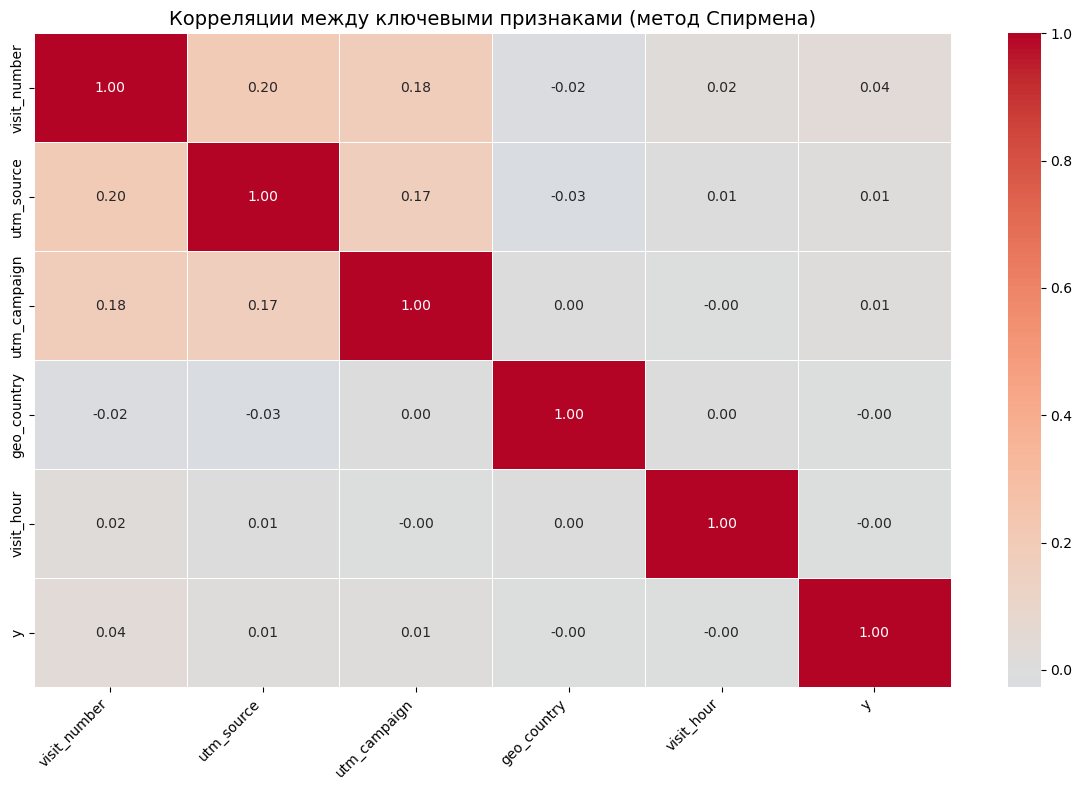

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Выбираем ключевые числовые признаки
numeric_features = [
    'visit_number', 'utm_source', 'utm_campaign',
    'geo_country', 'visit_hour', 'y'
]

# Фильтруем данные и вычисляем корреляции
corr_matrix = df_sessions[numeric_features].corr(method='spearman')

# Настраиваем визуализацию
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot_kws={'size': 10}
)
plt.title('Корреляции между ключевыми признаками (метод Спирмена)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Тепловая карта активности по времени

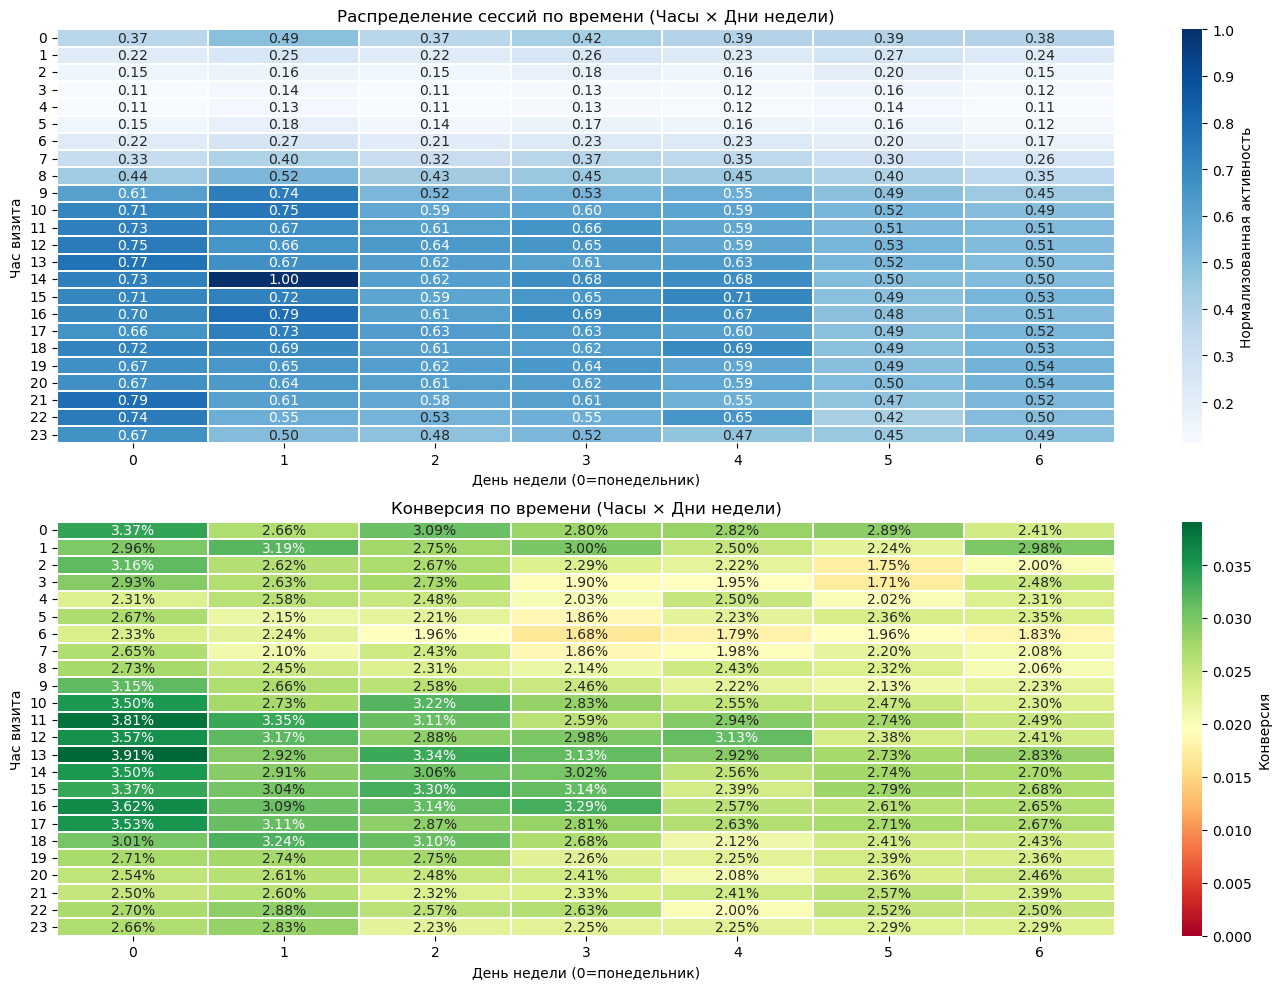

In [63]:
# Создаем сводную таблицу
time_heatmap_data = df_sessions.pivot_table(
    index='visit_hour',
    columns='dayofweek',
    values='y',
    aggfunc=['count', 'mean']
)

# Нормализуем количество сессий
session_norm = (time_heatmap_data['count'] / time_heatmap_data['count'].max().max())

# Визуализация
plt.figure(figsize=(14, 10))

# График активности сессий
plt.subplot(2, 1, 1)
sns.heatmap(
    session_norm,
    cmap='Blues',
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={'label': 'Нормализованная активность'}
)
plt.title('Распределение сессий по времени (Часы × Дни недели)')
plt.xlabel('День недели (0=понедельник)')
plt.ylabel('Час визита')

# График конверсий
plt.subplot(2, 1, 2)
sns.heatmap(
    time_heatmap_data['mean'],
    cmap='RdYlGn',
    annot=True,
    fmt=".2%",
    linewidths=0.3,
    vmin=0,
    vmax=time_heatmap_data['mean'].max().max(),
    cbar_kws={'label': 'Конверсия'}
)
plt.title('Конверсия по времени (Часы × Дни недели)')
plt.xlabel('День недели (0=понедельник)')
plt.ylabel('Час визита')

plt.tight_layout()
plt.show()

#### Рассмотрим конверсию параметров

In [65]:
def conversion(df):
    # График с распределением целевого признака
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x='y')
    plt.title('Распределение целевого признака')
    plt.xticks([0, 1], ['Нет', 'Да'])
    plt.ylabel('Количество')

    # Добавление значений на график
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Интерпретация
    plt.figtext(0.5, -0.1, f"Конверсия распределена в два класса: {df['y'].value_counts(normalize=True).to_dict()}", ha="center", fontsize=10)

    plt.show()

    # Временные признаки
    for col in ['visit_hour', 'dayofweek', 'month']:
        plt.figure(figsize=(8, 4))
        ax = sns.barplot(data=df, x=col, y='y', estimator=lambda x: sum(x)/len(x))
        plt.title(f'Конверсия по {col}')
        plt.ylabel('Конверсия (доля y=1)')
        plt.xlabel(col)

        # Добавление значений на график
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

        # Интерпретация
        avg_conversion = df.groupby(col)['y'].mean().round(3).to_dict()
        plt.figtext(0.5, -0.1, f"Средняя конверсия по {col}: {avg_conversion}", ha="center", fontsize=10)

        plt.show()

    # Группы по числу визитов
    df['visit_number_group'] = pd.cut(df['visit_number'], 
                                      bins=[0, 1, 5, 10, 50, 100, 200], 
                                      labels=['1', '2-5', '6-10', '11-50', '51-100', '200+'])

    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=df, x='visit_number_group', y='y')
    plt.title('Конверсия в зависимости от номера визита')
    plt.xlabel('Группа номера визита')
    plt.ylabel('Конверсия')

    # Добавление значений на график
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Интерпретация
    visit_group_conversion = df.groupby('visit_number_group')['y'].mean().round(3).to_dict()
    plt.figtext(0.5, -0.1, f"Конверсия по группам визитов: {visit_group_conversion}", ha="center", fontsize=10)

    plt.show()

    # Часто встречающиеся страны/города
    for col in ['geo_country_frequent', 'geo_city_frequent']:
        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df, x=col, y='y', estimator=lambda x: sum(x)/len(x))
        plt.title(f'Средняя конверсия по: {col}')
        plt.xticks(rotation=45)
        plt.ylabel('Конверсия')

        # Добавление значений на график
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

        # Интерпретация
        avg_conversion = df.groupby(col)['y'].mean().round(3).to_dict()
        plt.figtext(0.5, -0.1, f"Средняя конверсия по {col}: {avg_conversion}", ha="center", fontsize=10)

        plt.show()

    # Бинарные признаки устройств и браузеров
    binary_cols = [col for col in df.columns if 
                   col.startswith('device_category_') or 
                   col.startswith('device_os_') or 
                   col.startswith('device_browser_')]

    for col in binary_cols:
        if df[col].nunique() <= 2:
            plt.figure(figsize=(6, 3))
            ax = sns.barplot(data=df, x=col, y='y')
            plt.title(f'Конверсия для: {col}')
            plt.xticks([0, 1], ['Нет', 'Да'])
            plt.ylabel('Конверсия')

            # Добавление значений на график
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

            # Интерпретация
            conversion_rate = df.groupby(col)['y'].mean().round(3).to_dict()
            plt.figtext(0.5, -0.1, f"Конверсия по {col}: {conversion_rate}", ha="center", fontsize=10)

            plt.show()


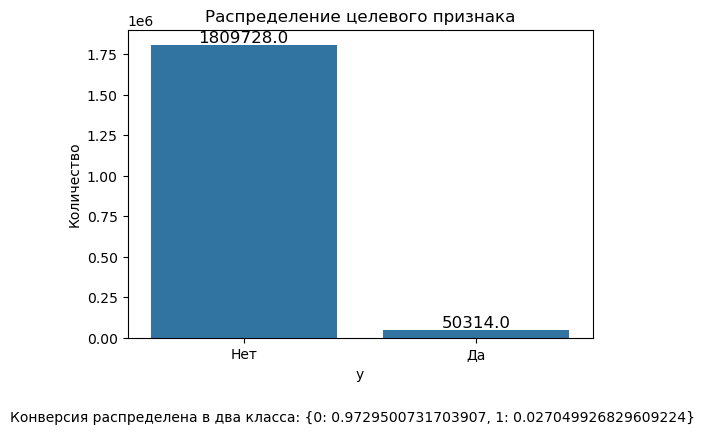

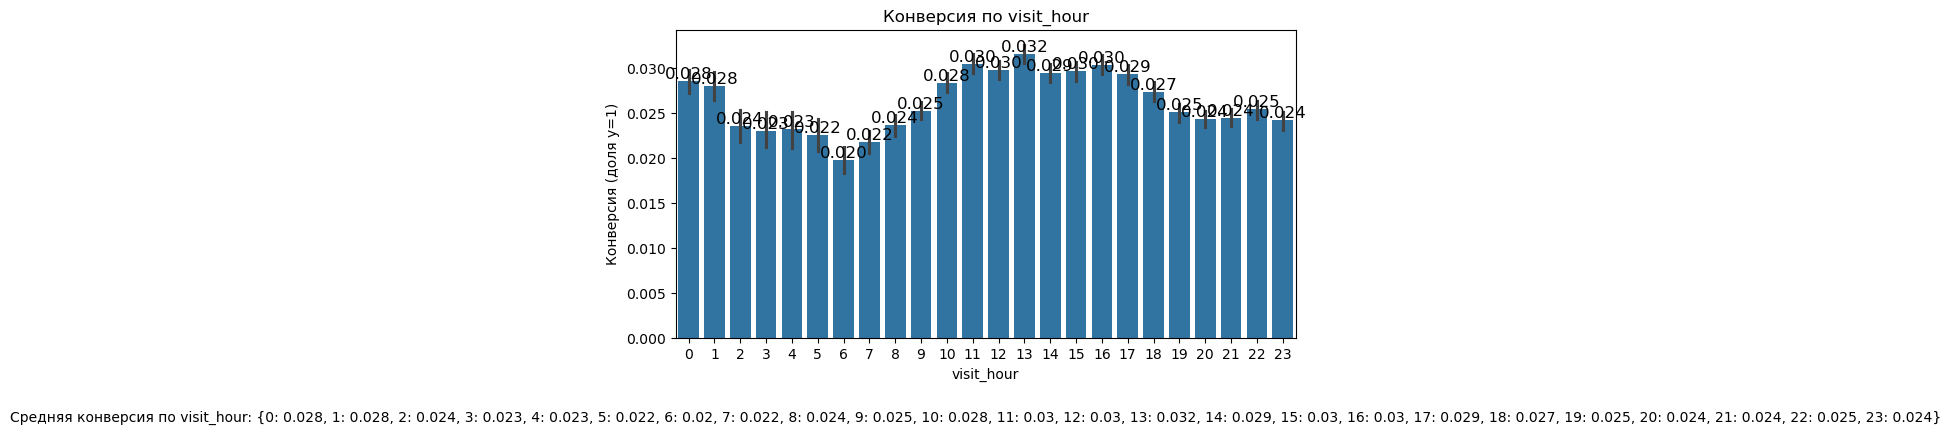

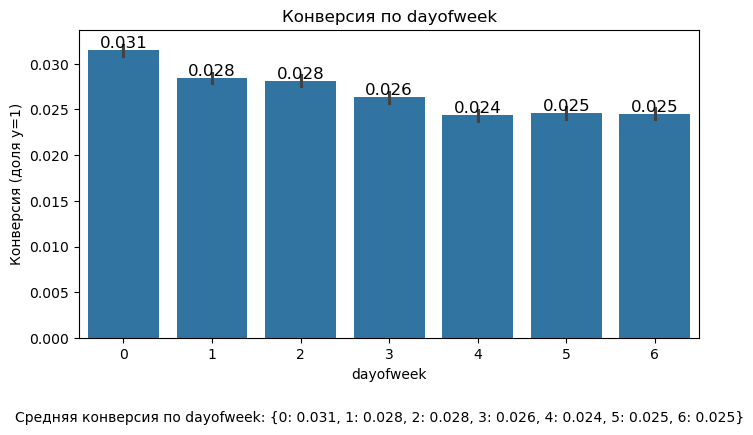

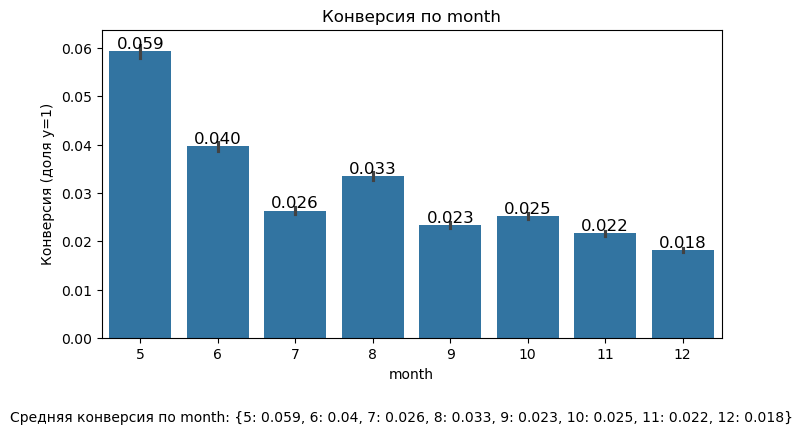

C:\Users\Roman\AppData\Local\Temp\ipykernel_28516\446743382.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_group_conversion = df.groupby('visit_number_group')['y'].mean().round(3).to_dict()


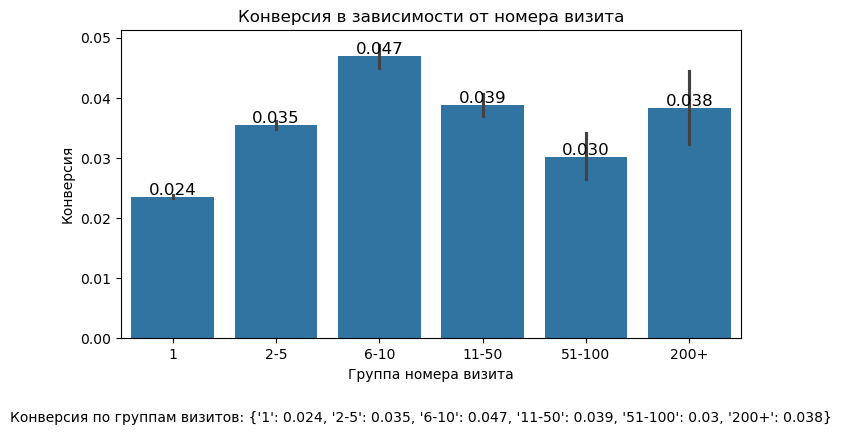

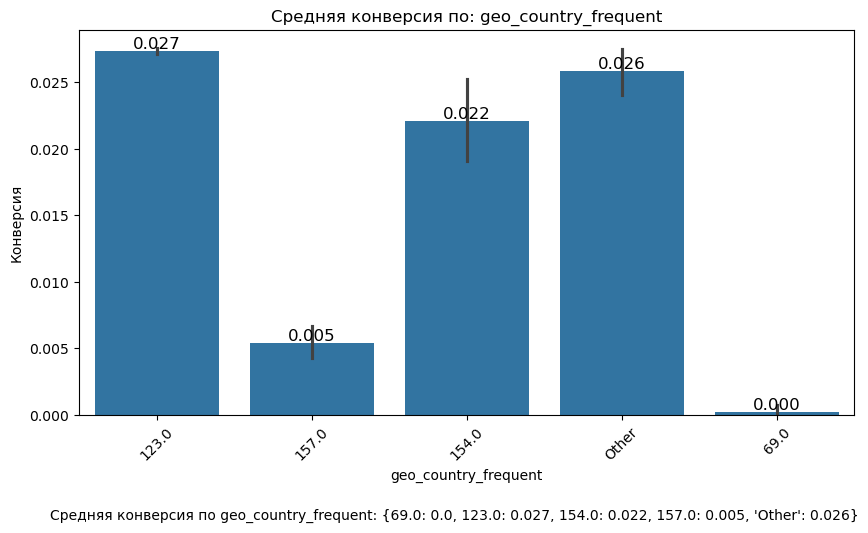

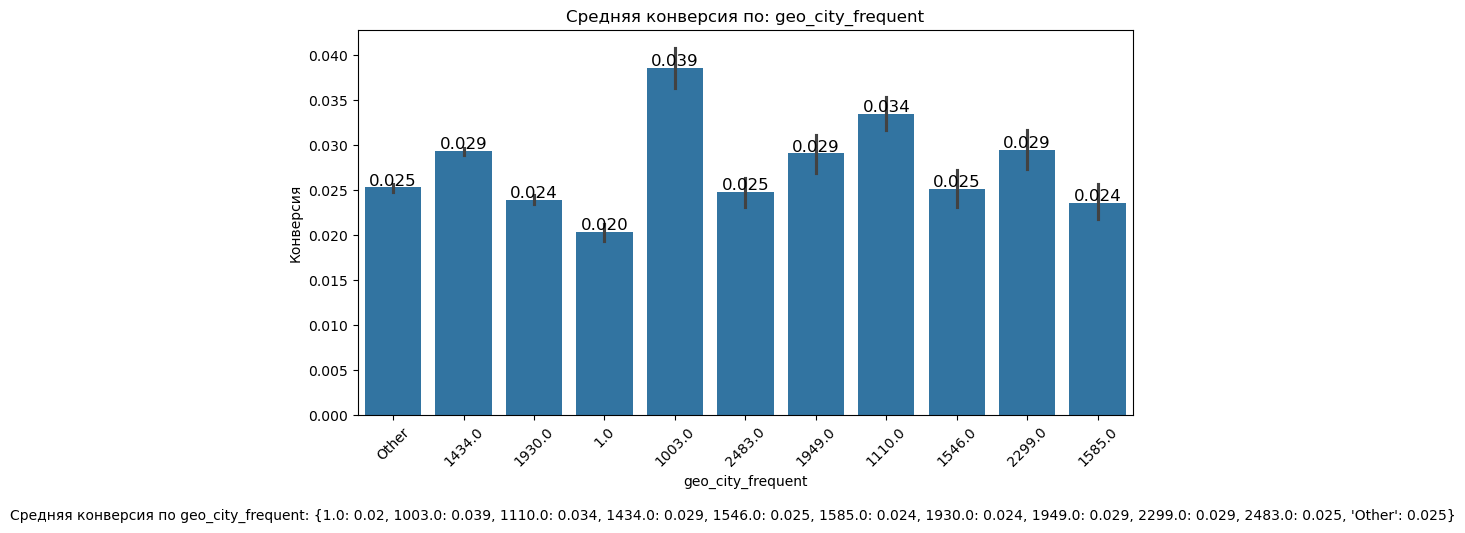

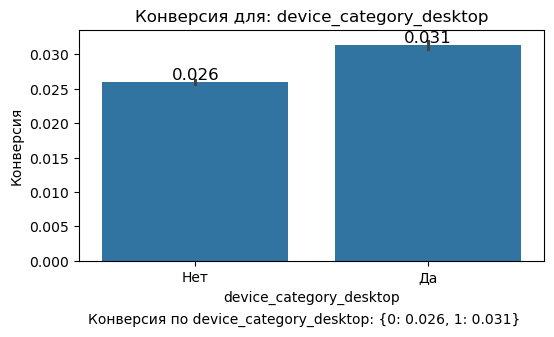

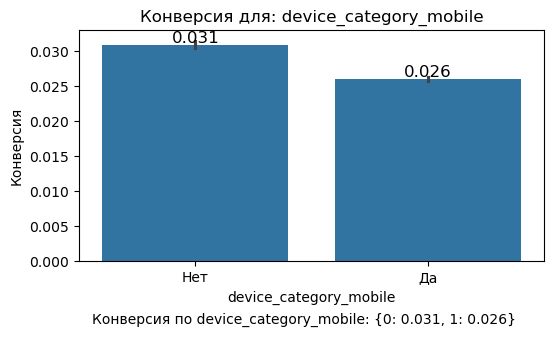

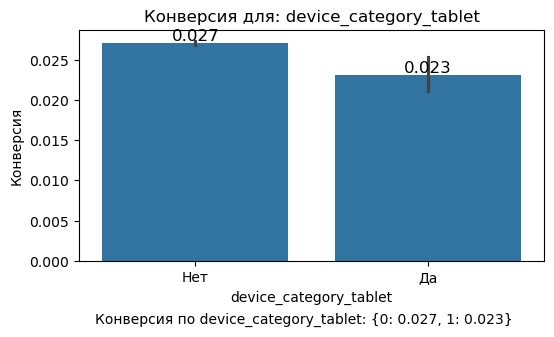

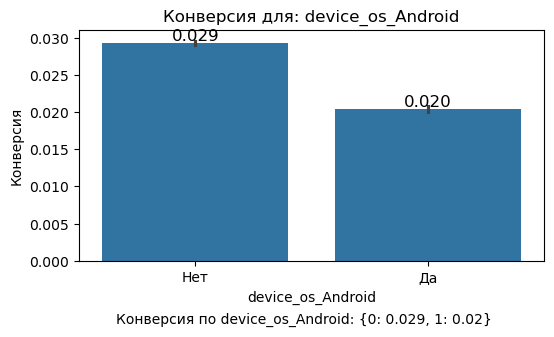

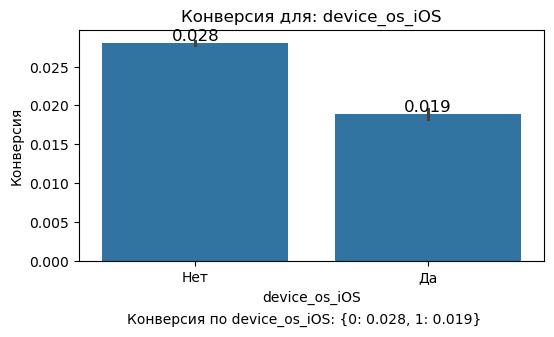

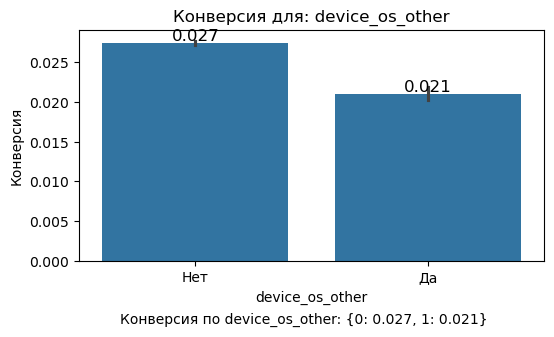

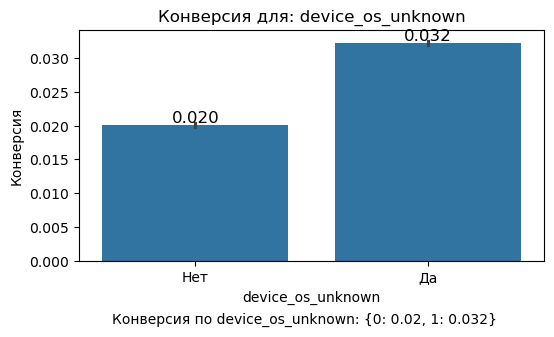

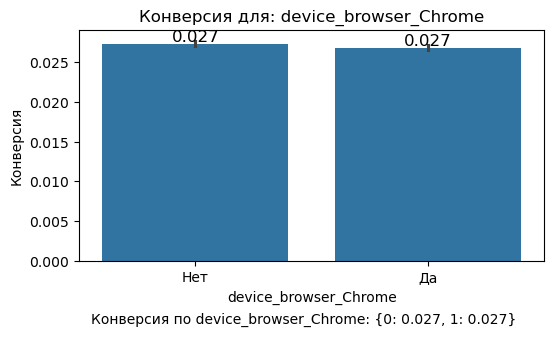

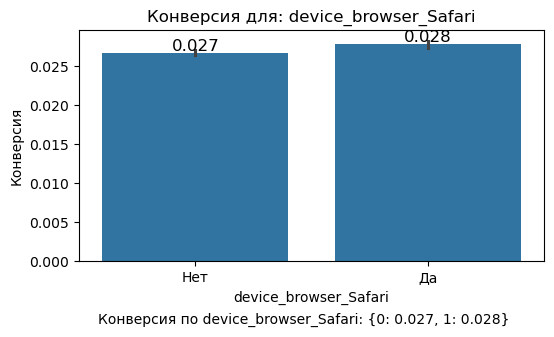

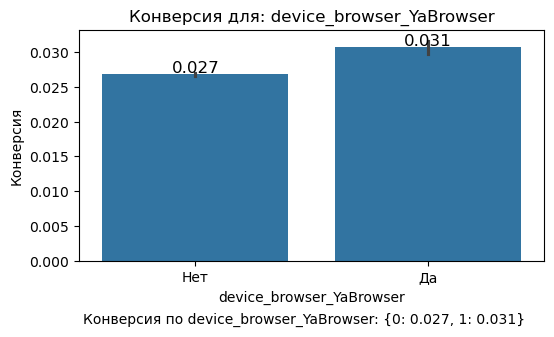

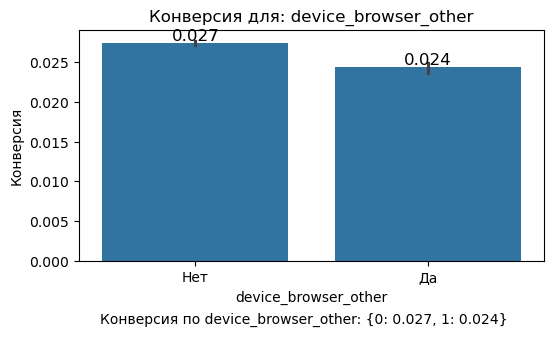

In [66]:
conversion(df_sessions)

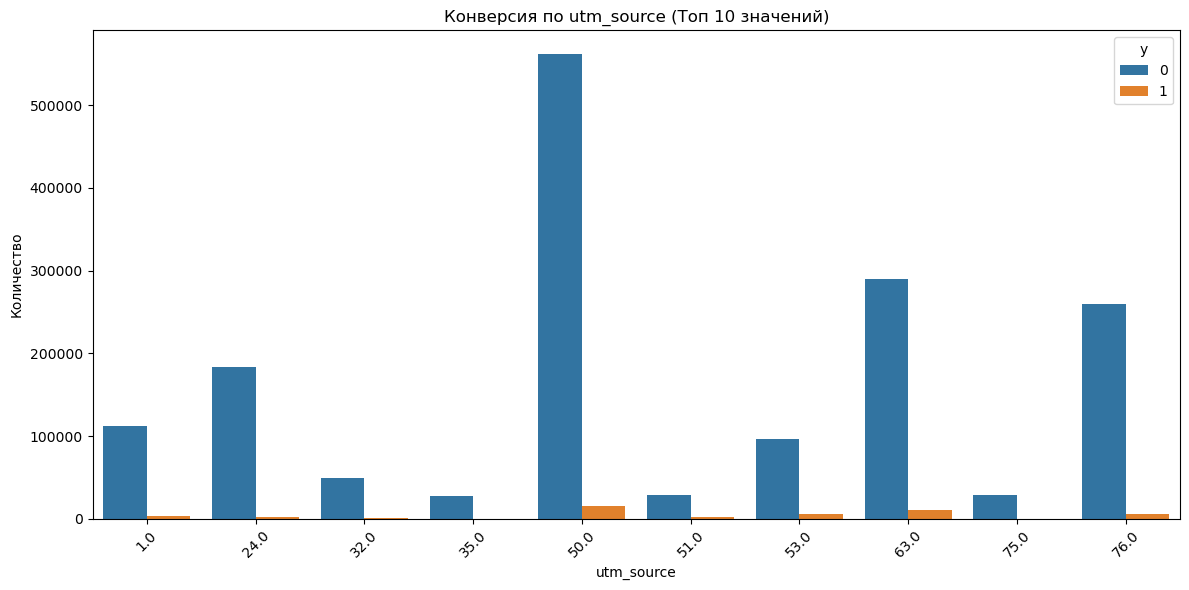

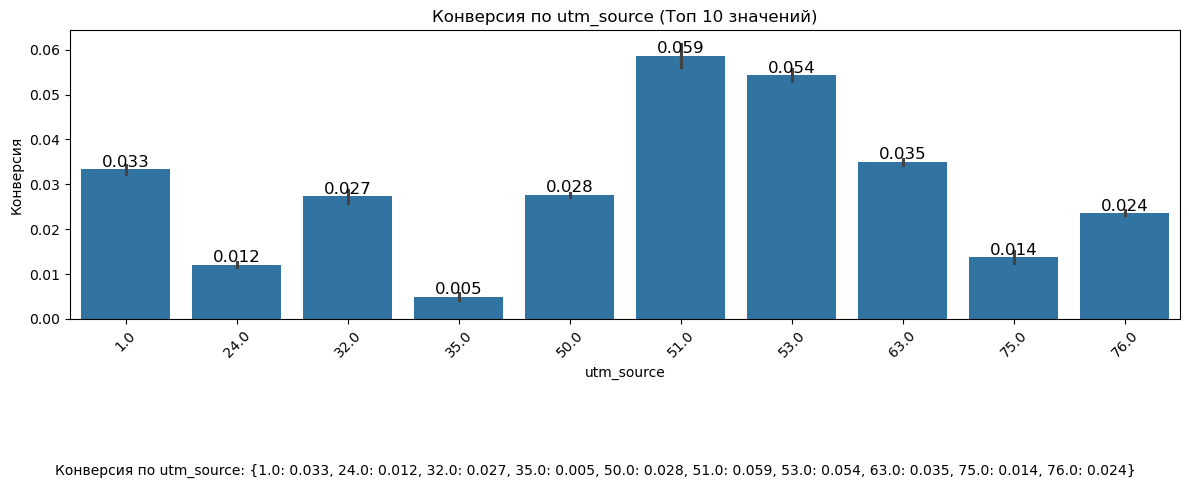

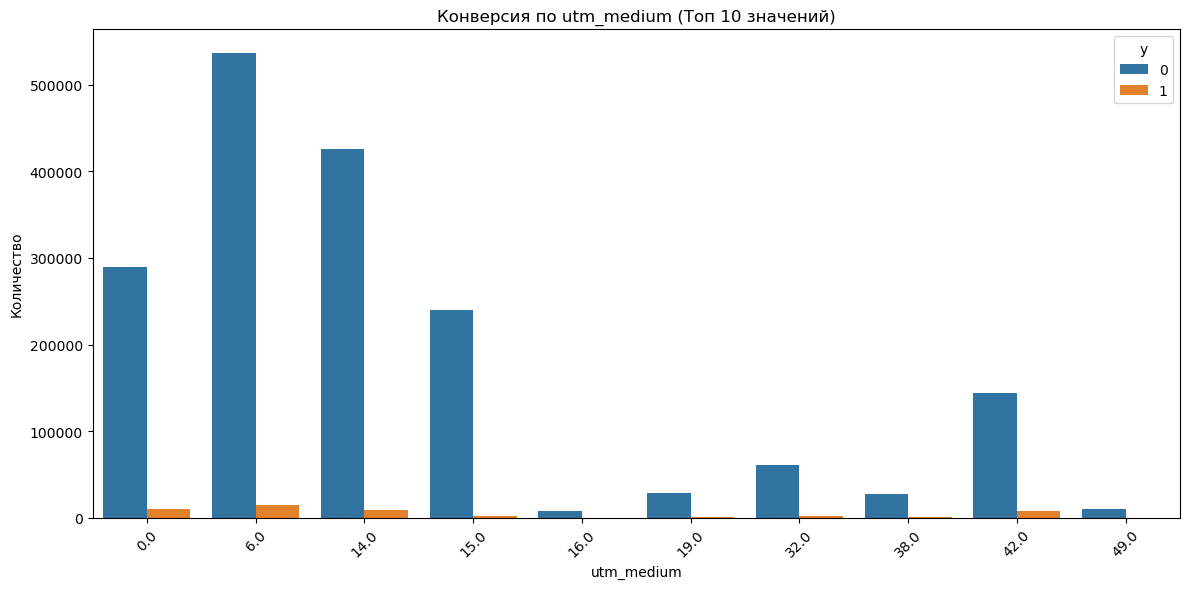

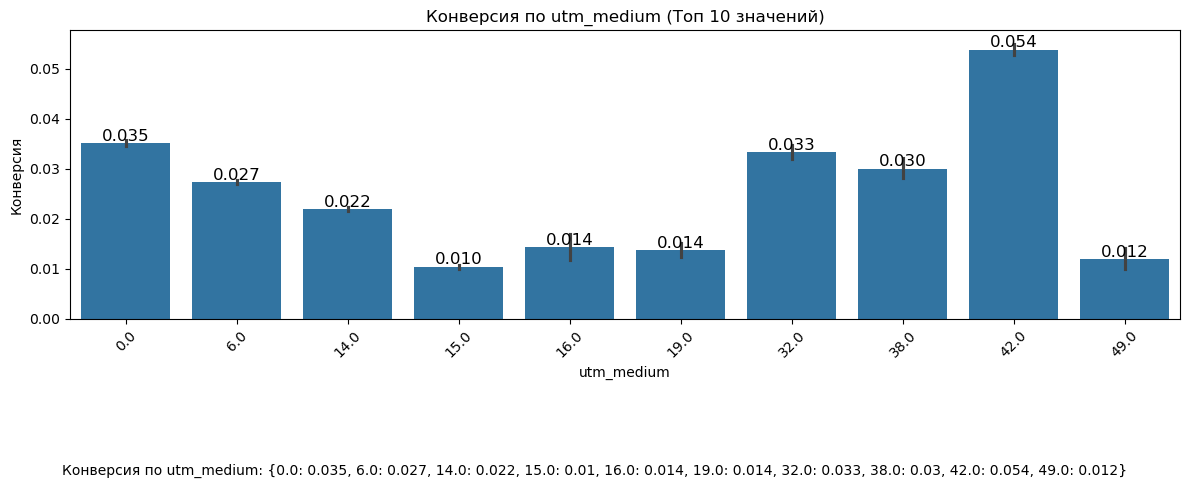

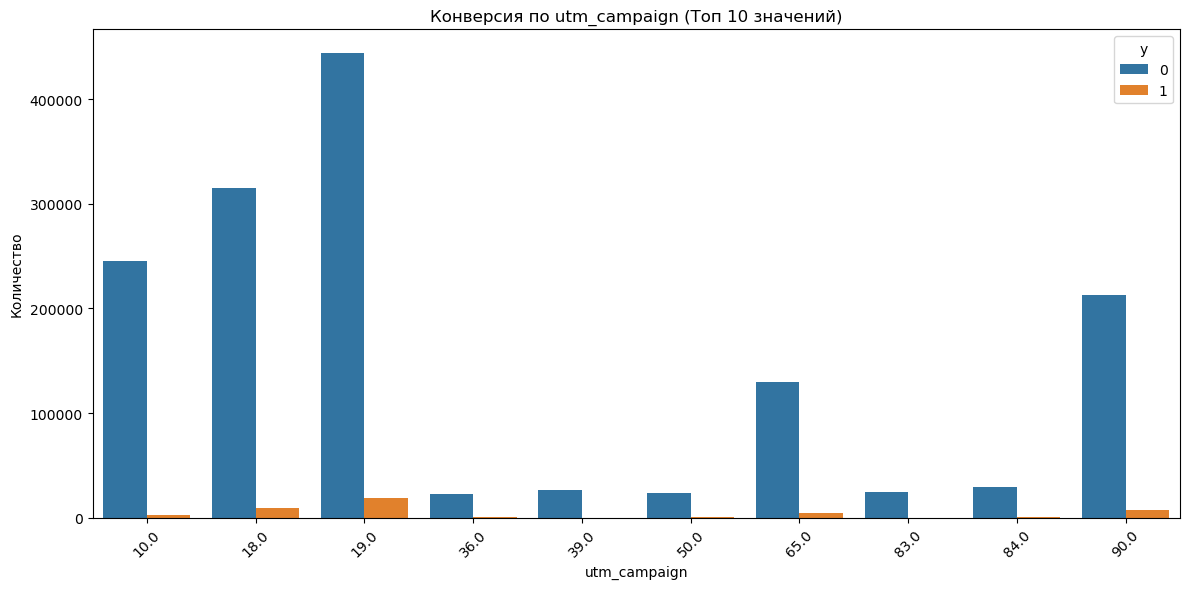

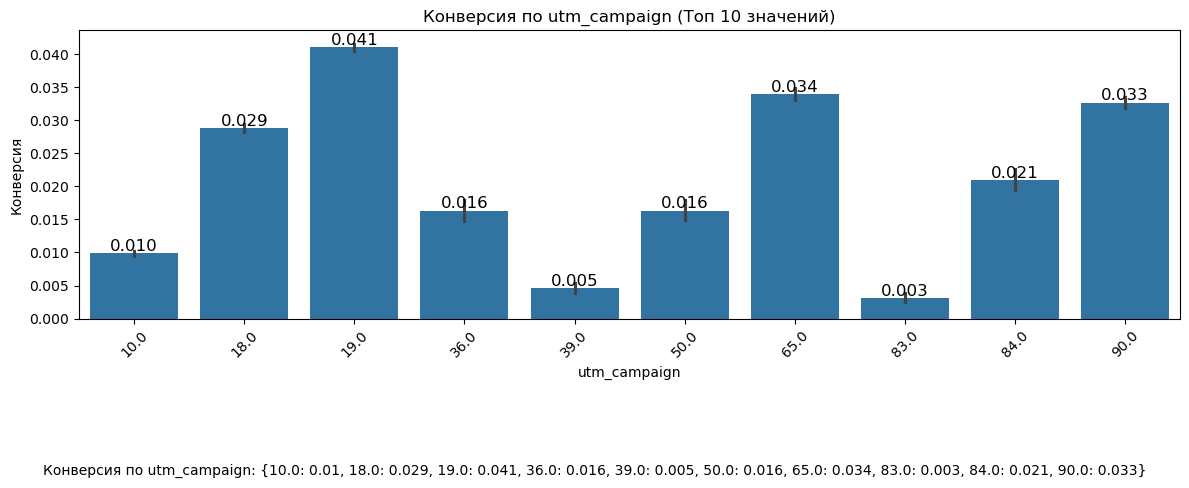

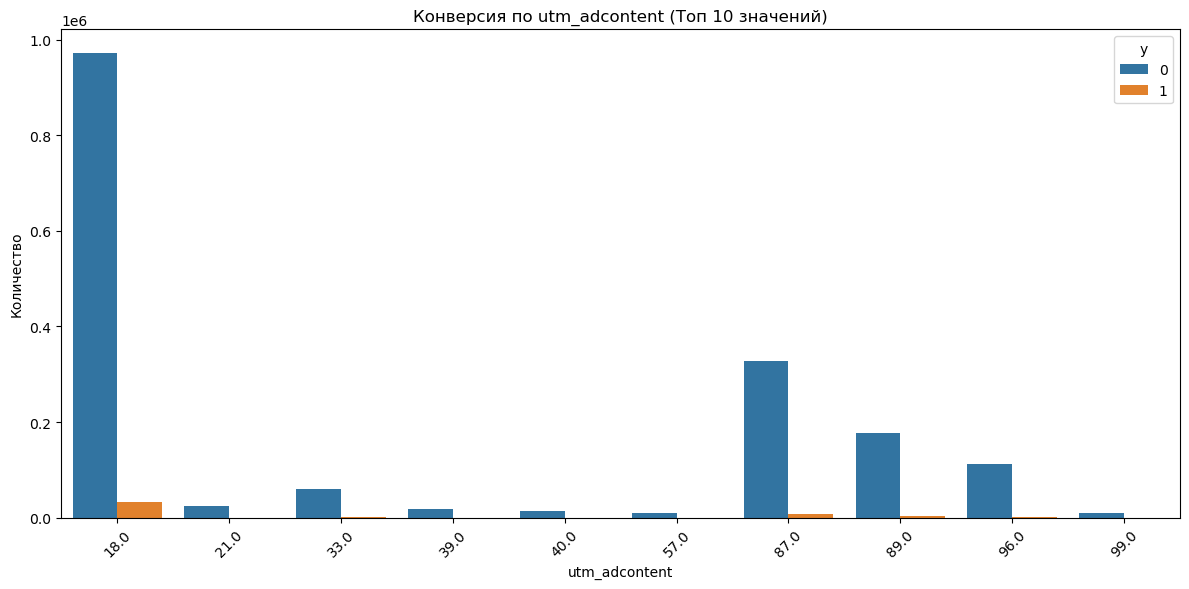

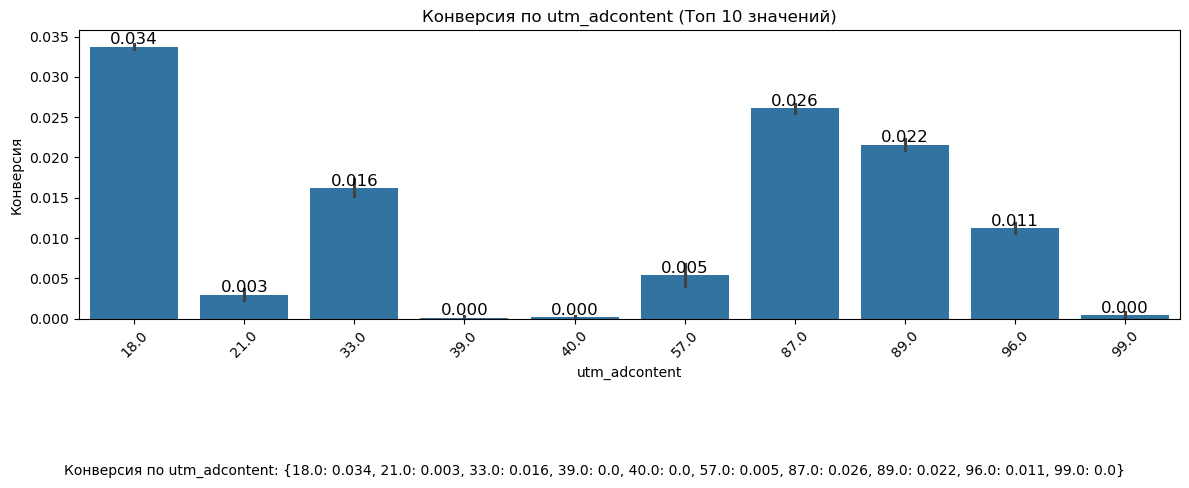

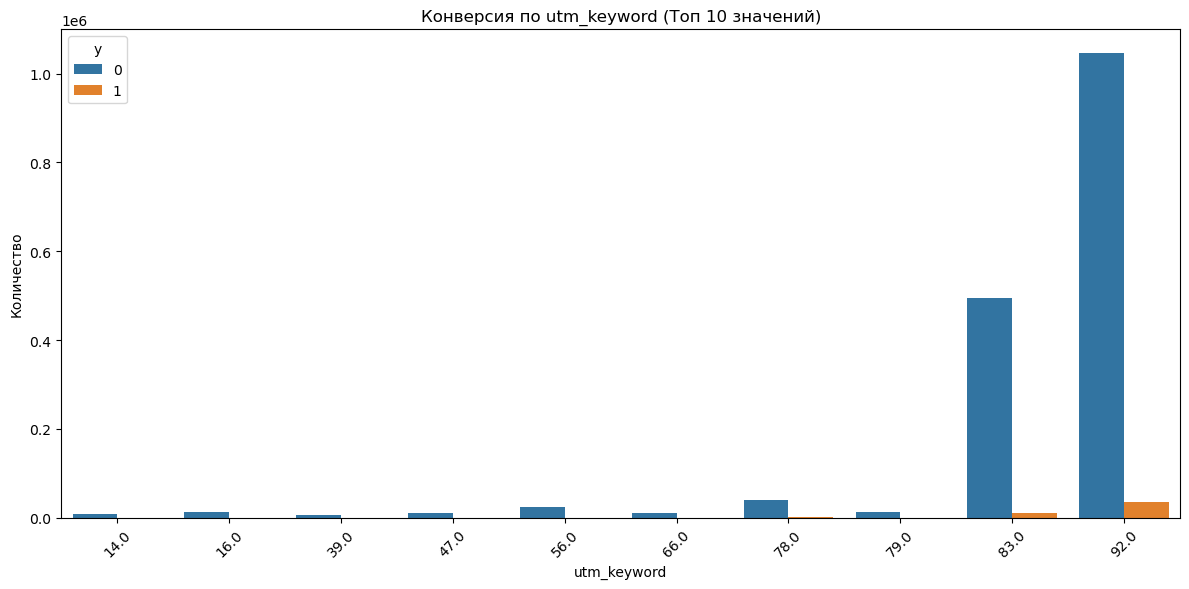

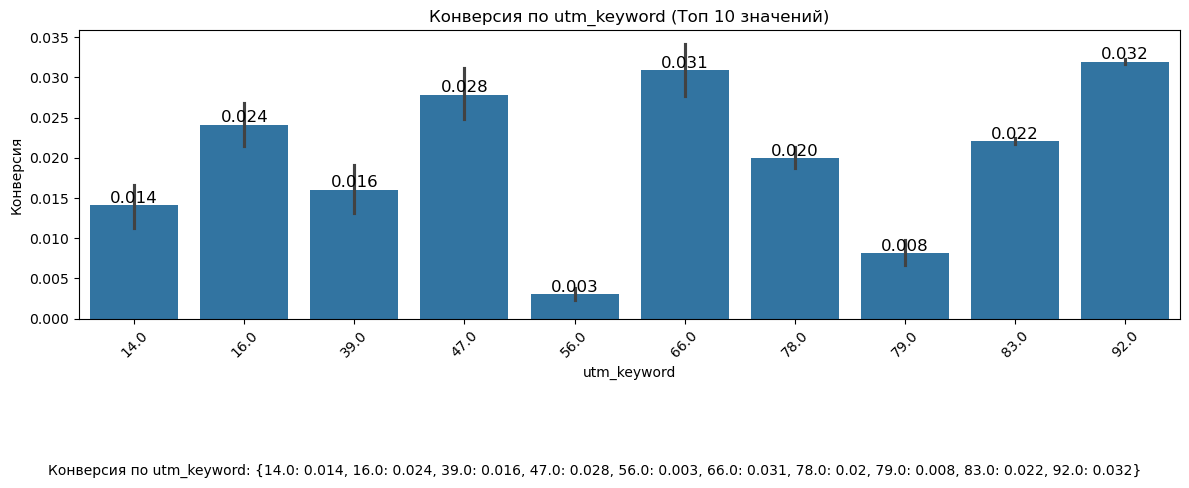

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# UTM-метки
utm_cols = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword']

for col in utm_cols:
    # Выбираем топ-10 самых популярных значений
    top_utm_values = df_sessions[col].value_counts().nlargest(10).index
    df_top_utm = df_sessions[df_sessions[col].isin(top_utm_values)]

    # Создаем график
    plt.figure(figsize=(12, 6))
    
    # Отображаем countplot для топ-10 значений
    sns.countplot(data=df_top_utm, x=col, hue='y')
    
    # Настроим заголовок и подписи осей
    plt.title(f'Конверсия по {col} (Топ 10 значений)')
    plt.xticks(rotation=45)
    plt.ylabel('Количество')
    
    # Показываем график
    plt.tight_layout()
    plt.show()

    # Для барплота с конверсией
    plt.figure(figsize=(12, 4))
    ax = sns.barplot(data=df_top_utm, x=col, y='y', estimator=lambda x: sum(x) / len(x))
    plt.title(f'Конверсия по {col} (Топ 10 значений)')
    plt.xticks(rotation=45)
    plt.ylabel('Конверсия')

    # Добавление значений на график
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Интерпретация — выводим конверсию для каждой категории
    conversion_rate = df_top_utm.groupby(col)['y'].mean().round(3).to_dict()
    plt.figtext(0.5, -0.2, f"Конверсия по {col}: {conversion_rate}", ha="center", fontsize=10)

    # Показываем график
    plt.tight_layout()  # Это гарантирует, что все элементы поместятся в фигуру
    plt.show()


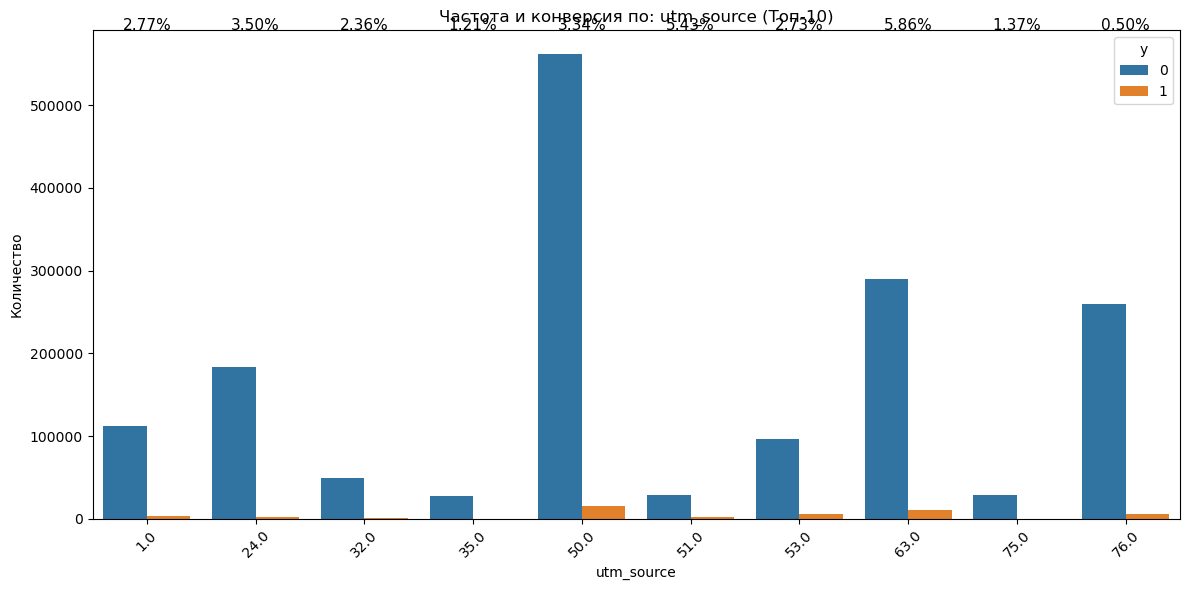

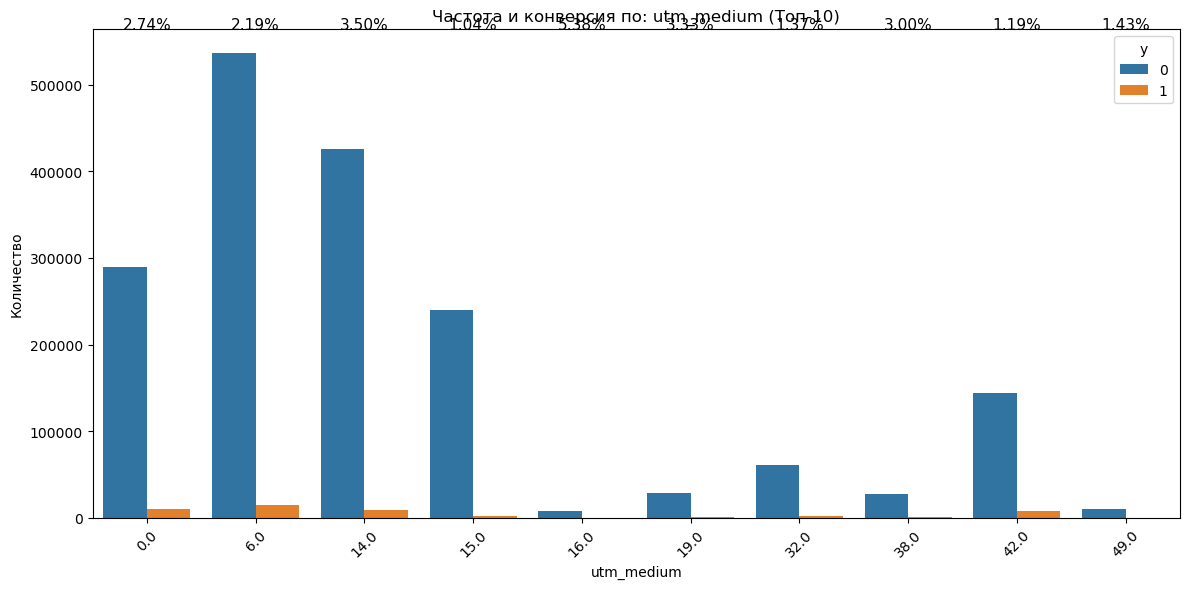

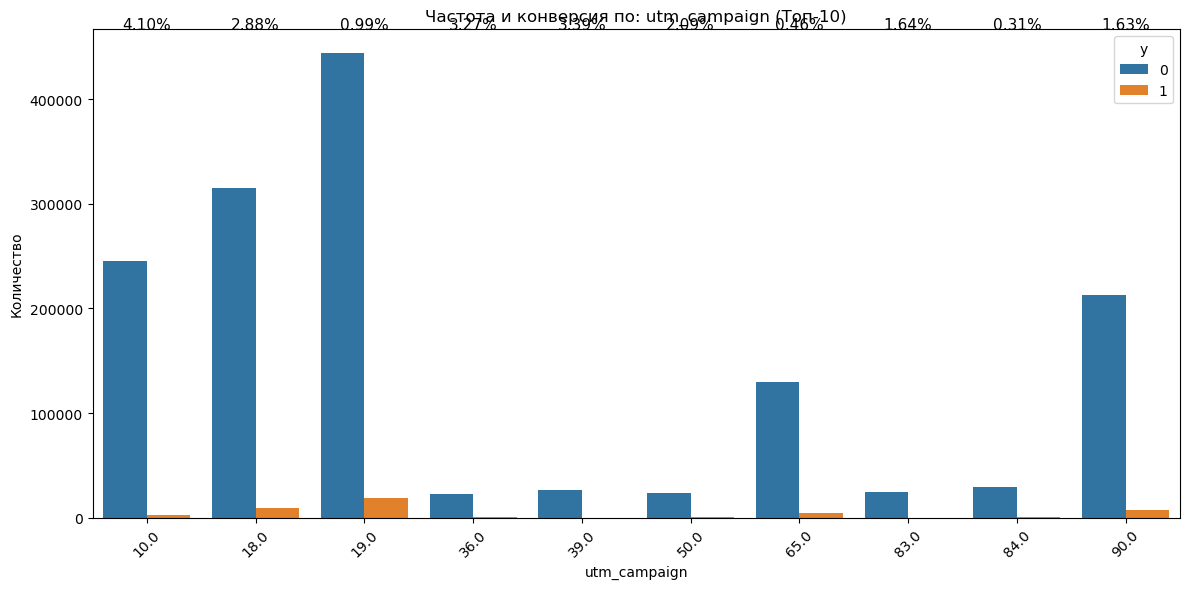

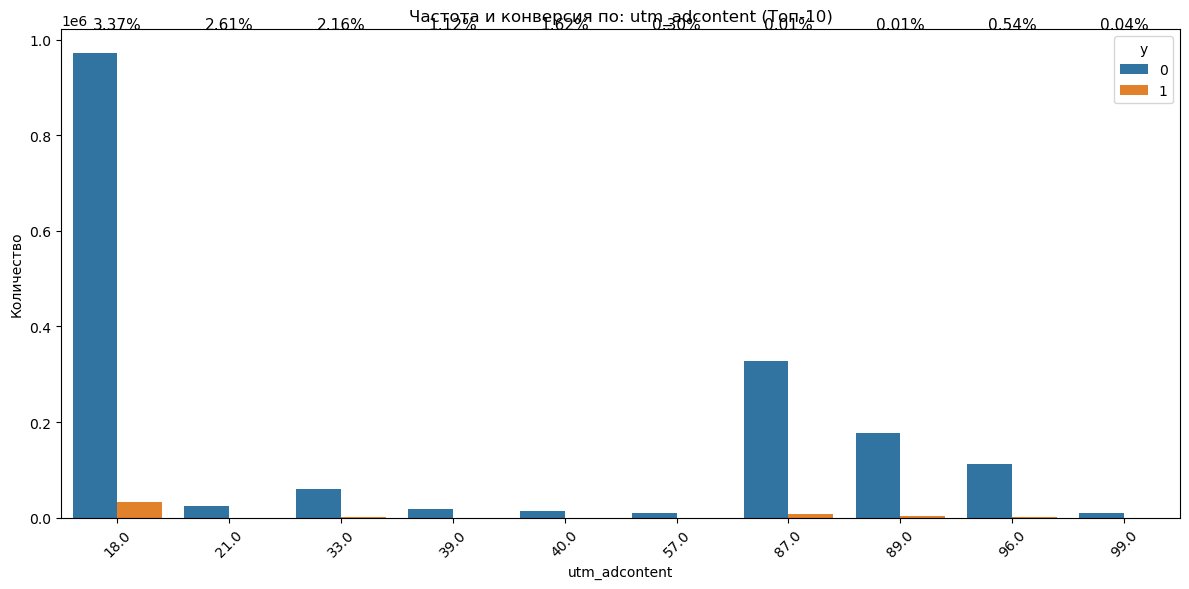

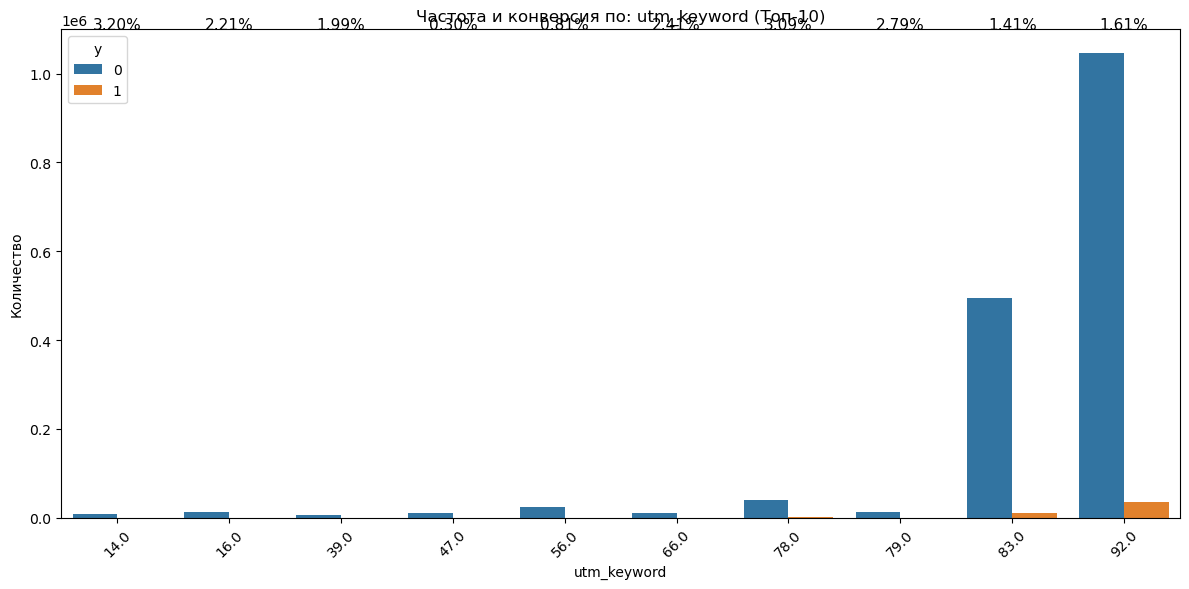

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

utm_cols = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword']

for col in utm_cols:
    top_vals = df_sessions[col].value_counts().nlargest(10).index
    df_top = df_sessions[df_sessions[col].isin(top_vals)]

    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df_top, x=col, hue='y')
    plt.title(f'Частота и конверсия по: {col} (Топ-10)')
    plt.xticks(rotation=45)
    plt.ylabel('Количество')

    # Вычисляем конверсии
    conversion_rates = df_top.groupby(col)['y'].mean()
    max_height = max([p.get_height() for p in ax.patches])  # высота самого высокого столбца

    # Подписи на едином уровне (выше всех столбиков)
    for i, category in enumerate(top_vals):
        conv = conversion_rates[category]
        ax.text(i, max_height * 1.05, f'{conv:.2%}', ha='center', fontsize=11, color='black')

    plt.tight_layout()
    plt.show()


Преобразование данных (стандартизация и нормализация)

1. Выбор признаков для преобразования

In [71]:
numeric_features = [
    'visit_number',
    'utm_source',
    'utm_campaign',
    'utm_medium',
    'geo_country',
    'visit_hour'
]

2. Анализ распределений

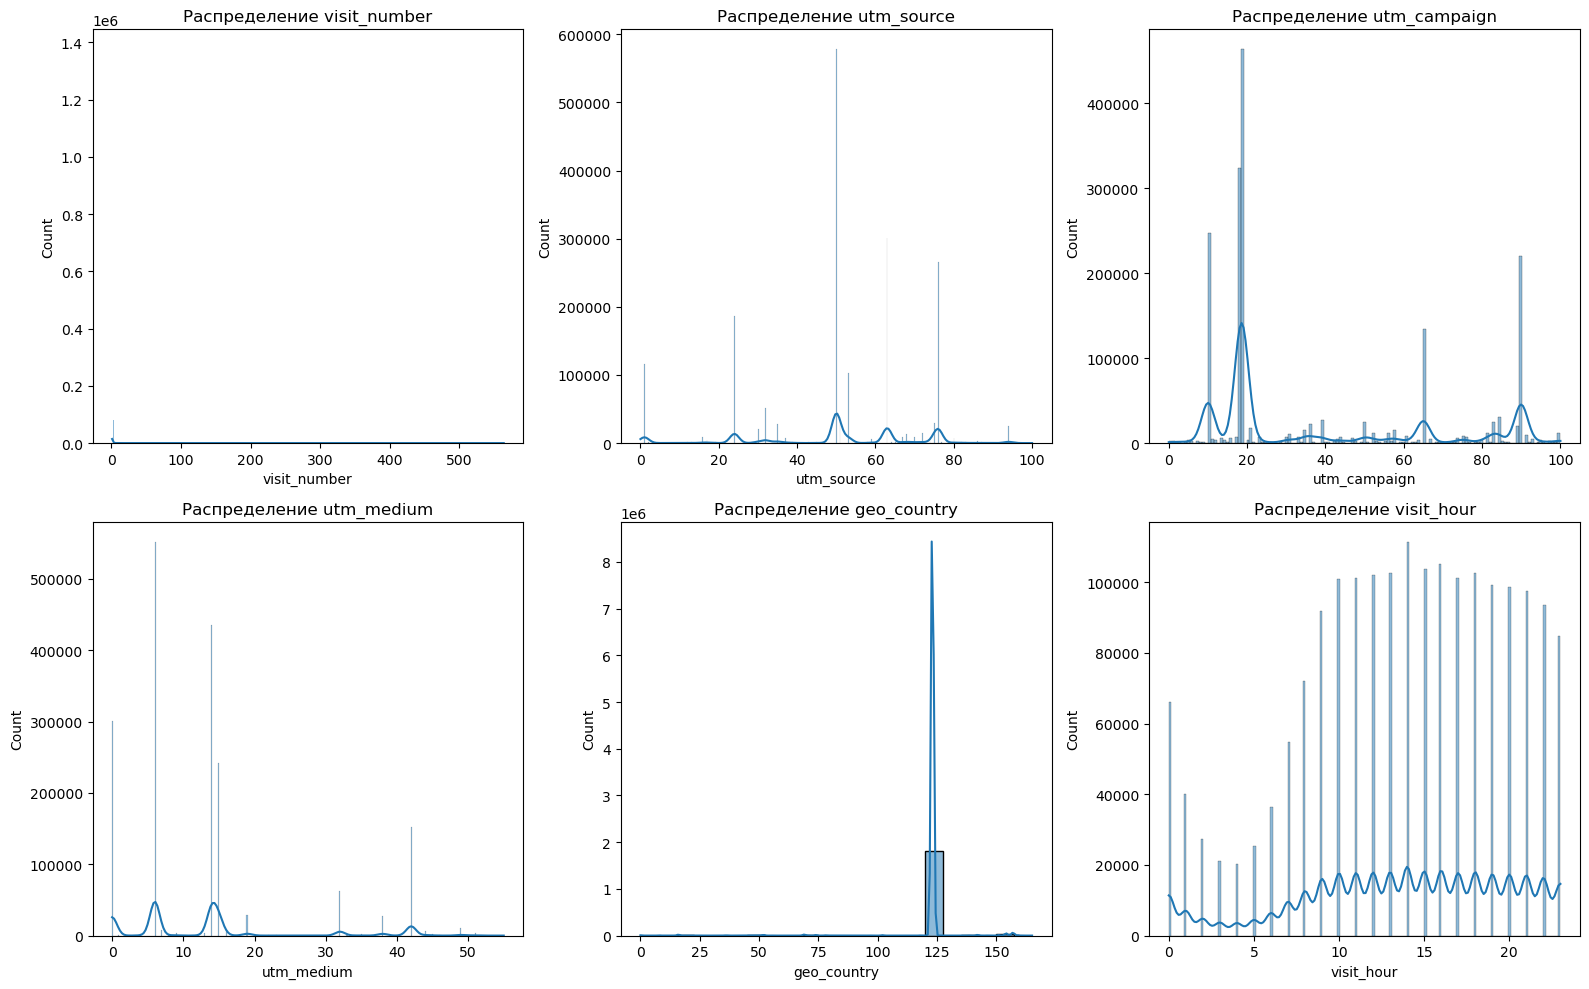

In [73]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_sessions[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

3. Логарифмическое преобразование

In [75]:
from scipy.stats import skew

# Вычисляем асимметрию
skewness = df_sessions[numeric_features].apply(lambda x: skew(x.dropna()))

# Применяем логарифм к признакам с асимметрией > 1
for col in skewness[skewness > 1].index:
    df_sessions[col+'_log'] = np.log1p(df_sessions[col])

4. Стандартизация

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sessions[numeric_features])
df_scaled = pd.DataFrame(df_scaled, columns=[f'{col}_z' for col in numeric_features])

5. Нормализация (Min-Max)

In [79]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
df_normalized = minmax.fit_transform(df_sessions[numeric_features])
df_normalized = pd.DataFrame(df_normalized, columns=[f'{col}_mm' for col in numeric_features])

6. Robust Scaling (для устойчивости к выбросам)

In [81]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
df_robust = robust.fit_transform(df_sessions[numeric_features])
df_robust = pd.DataFrame(df_robust, columns=[f'{col}_robust' for col in numeric_features])

7. Визуализация результатов

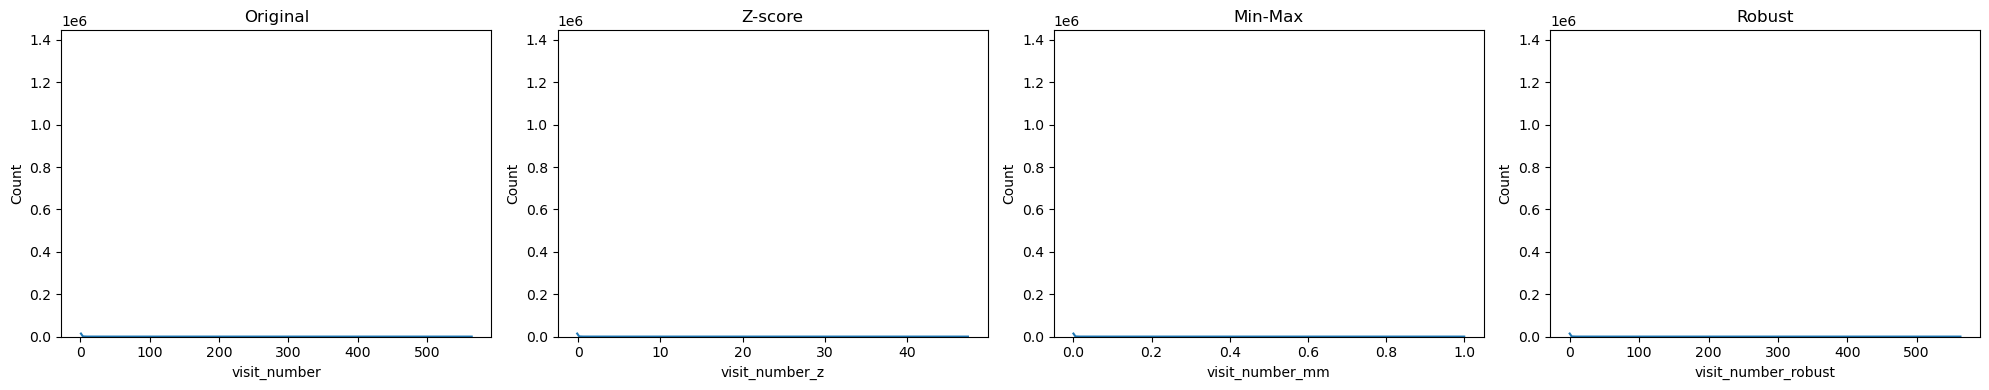

In [83]:
# Пример для visit_number
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

sns.histplot(df_sessions['visit_number'], kde=True, ax=axes[0]).set_title('Original')
sns.histplot(df_scaled['visit_number_z'], kde=True, ax=axes[1]).set_title('Z-score')
sns.histplot(df_normalized['visit_number_mm'], kde=True, ax=axes[2]).set_title('Min-Max')
sns.histplot(df_robust['visit_number_robust'], kde=True, ax=axes[3]).set_title('Robust')

plt.tight_layout()
plt.show()

8.

| **Метод**       | **Когда использовать**               | **Преимущества**                          |
|------------------|--------------------------------------|-------------------------------------------|
| Z-score          | Нормальное распределение             | Сохраняет форму распределения             |
| Min-Max          | Ограниченный диапазон (нейросети)    | Фиксированный диапазон [0,1]              |
| Robust           | Наличие выбросов                     | Устойчив к экстремальным значениям        |
| Log Transform    | Сильная асимметрия                   | Уменьшает skewness                        |

9. Финальное преобразование

In [86]:
# Импортируем необходимые библиотеки и модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # Если используете XGBoost
from sklearn.pipeline import Pipeline

# Предположим, что у вас уже определён `preprocessor`
# Например:
# from sklearn.compose import ColumnTransformer
# preprocessor = ColumnTransformer([...])

# Создаем пайплайн с конкретной моделью
pipeline = Pipeline([
    # Выберите одну из моделей:
    ('model', LogisticRegression()),               # Логистическая регрессия
    # ('model', RandomForestClassifier()),         # Случайный лес
    # ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # XGBoost
])


In [87]:
final_df = pd.concat([
    df_scaled,
    df_normalized,
    df_robust,
    df_sessions[['device_category_mobile', 'y']]
], axis=1)

final_df.to_csv('transformed_data.csv', index=False)

#### Построим матрицу корреляции

ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ, ДА МЫ ПОДГОТОВИМ КАРТУ ЛУЧШЕ, СЕЙЧАС НЕ УСПЕВАЕМ ЗАФИЛЬТРОВАТЬ ФРЕЙМ

Топ-20 коррелирующих признаков:
                                 y
y                         1.000000
device_os_unknown         0.036807
visit_number_log          0.034164
utm_keyword               0.025945
visit_number              0.025320
utm_medium                0.020619
device_category_desktop   0.013237
device_brand              0.006195
device_browser_YaBrowser  0.006166
utm_source                0.003327
device_browser_Safari     0.002865
day                       0.001877
session_id                0.000796
utm_campaign             -0.000010
visit_hour               -0.000060
geo_city                 -0.000829
device_browser_Chrome    -0.001500
geo_country              -0.001613
device_category_tablet   -0.002458
device_browser_other     -0.006312


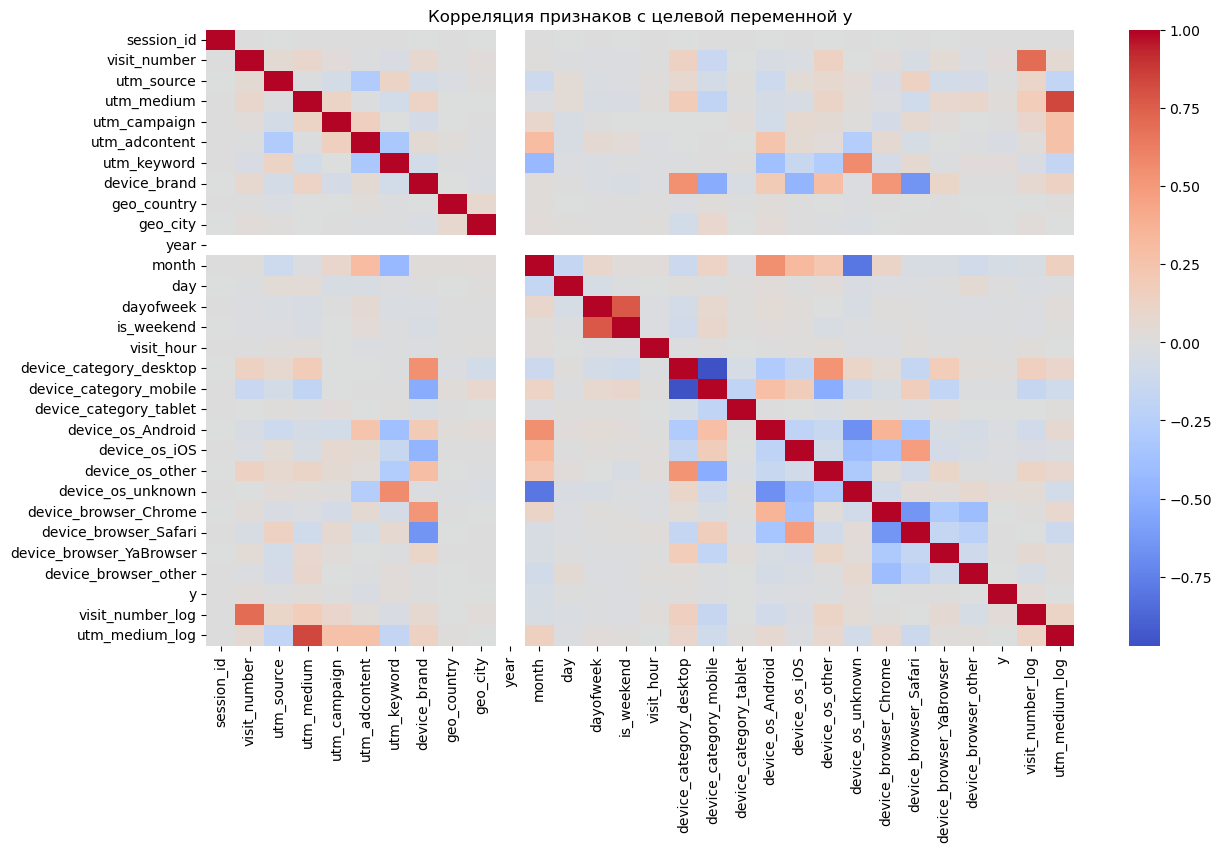

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Проверяем наличие целевой переменной 'y'
if 'y' not in df_sessions.columns:
    raise KeyError("Столбец 'y' отсутствует в DataFrame. Проверьте данные!")

# Убедимся, что 'y' является числовым
if not np.issubdtype(df_sessions['y'].dtype, np.number):
    # Попробуем преобразовать в число (например, если это категория)
    df_sessions['y'] = pd.to_numeric(df_sessions['y'], errors='coerce')
    # Если остались пропуски, удалим их
    df_sessions.dropna(subset=['y'], inplace=True)

# Выбираем только числовые признаки (включая 'y')
numeric_cols = df_sessions.select_dtypes(include=[np.number]).columns

# Вычисляем корреляцию с целевой переменной
corr_with_target = df_sessions[numeric_cols].corr()[['y']].sort_values(by='y', ascending=False)

# Топ-20 признаков, коррелирующих с 'y'
print("Топ-20 коррелирующих признаков:")
print(corr_with_target.head(20))

# Тепловая карта (исключим 'y' для наглядности, если нужно)
plt.figure(figsize=(14, 8))
sns.heatmap(df_sessions[numeric_cols].corr(),
            cmap='coolwarm',
            center=0,
            annot=False)
plt.title('Корреляция признаков с целевой переменной y')
plt.show()

In [92]:
df_sessions = df_sessions.drop(columns=['year'])

#### Сокращение пространства признаков с помощью UMAP

In [94]:
!pip install umap-learn
import umap

def plot_correlation_with_umap_optimized(df, target='y', n_neighbors=15, min_dist=0.1, max_samples=10000):
    # Выбираем только числовые колонки
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Убираем целевой признак, если он числовой
    numeric_cols = numeric_cols[numeric_cols != target]

    # Если размер данных слишком большой, возьмём случайную подвыборку (до max_samples)
    if len(df) > max_samples:
        df = df.sample(n=max_samples, random_state=42)

    # Инициализация UMAP с многопоточностью
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=-1)

    # Применяем UMAP для уменьшения размерности до 2
    umap_result = umap_model.fit_transform(df[numeric_cols])

    # Создаём DataFrame с результатами UMAP
    umap_df = pd.DataFrame(umap_result, columns=['UMAP_1', 'UMAP_2'])

    # Добавляем целевой признак
    umap_df[target] = df[target].values

    # Визуализируем результаты в 2D
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue=target, data=umap_df, palette="coolwarm", s=50, edgecolor='k', alpha=0.7)
    plt.title(f'UMAP — Проекция признаков с целевым признаком ({target})')
    plt.legend(title=target)
    plt.show()

# Пример использования:
#plot_correlation_with_umap_optimized(df_sessions)

In [95]:
import pandas as pd
import numpy as np

def drop_low_high_corr(df, target, low_thr=0.05, high_thr=0.9):
    """
    df      : pandas DataFrame
    target  : имя столбца‑цели
    low_thr : нижний порог |corr| с целью
    high_thr: верхний порог |corr| между признаками
    """
    # 1) только числовые признаки
    num_cols = df.select_dtypes(include=np.number).columns.drop(target)

    # 2) низкая корреляция с целью
    corr_with_target = df[num_cols].corrwith(df[target]).abs()
    low_corr_feats = corr_with_target[corr_with_target < low_thr].index.tolist()

    # 3) высокая взаимная корреляция
    corr_matrix = df[num_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    high_corr_feats = [
        column for column in upper.columns
        if any(upper[column] > high_thr)
    ]

    # 4) объединяем и удаляем
    to_drop = set(low_corr_feats + high_corr_feats)
    df_clean = df.drop(columns=to_drop)

    print(f"Удалено {len(to_drop)} столбцов: {sorted(to_drop)}")
    return df_clean

# ── пример использования ───────────────────────────────────
df_sessions_clean = drop_low_high_corr(df_sessions, target='y', low_thr=0.005, high_thr=0.85)


Удалено 17 столбцов: ['day', 'device_brand', 'device_browser_Chrome', 'device_browser_Safari', 'device_browser_YaBrowser', 'device_browser_other', 'device_category_mobile', 'device_category_tablet', 'device_os_other', 'geo_city', 'geo_country', 'is_weekend', 'session_id', 'utm_campaign', 'utm_medium_log', 'utm_source', 'visit_hour']


In [96]:
df_sessions_clean.head(5)

,visit_number,utm_medium,utm_adcontent,utm_keyword,month,dayofweek,device_category_desktop,device_os_Android,device_os_iOS,device_os_unknown,y,geo_country_frequent,geo_city_frequent,visit_number_group,visit_number_log
0,1,6.0,89.0,83.0,11,2,0,1,0,0,0,123.0,Other,1,0.693147
1,1,15.0,96.0,14.0,11,6,0,1,0,0,0,123.0,1434.0,1,0.693147
2,1,6.0,89.0,83.0,12,1,0,1,0,0,0,123.0,Other,1,0.693147
3,1,14.0,27.0,92.0,5,5,0,0,0,1,0,123.0,1434.0,1,0.693147
4,2,14.0,87.0,92.0,5,5,0,0,0,1,0,123.0,1434.0,2-5,1.098612


## 4. Обучение модели

In [147]:
df_sessions = df_sessions_clean

df_sessions['geo_country_frequent'] = df_sessions['geo_country_frequent'].replace('Other', -1)
df_sessions['geo_city_frequent'] = df_sessions['geo_city_frequent'].replace('Other', -1)
df_sessions['geo_city_frequent'].unique()

C:\Users\Roman\AppData\Local\Temp\ipykernel_28516\3643647254.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sessions['geo_city_frequent'] = df_sessions['geo_city_frequent'].replace('Other', -1)


array([-1.000e+00,  1.434e+03,  1.930e+03,  1.000e+00,  1.003e+03,
        2.483e+03,  1.949e+03,  1.110e+03,  1.546e+03,  2.299e+03,
        1.585e+03])

In [149]:
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
le_city = LabelEncoder()
le_visit = LabelEncoder()

# Fit and transform each column
df_sessions['geo_country_frequent'] = le_country.fit_transform(df_sessions['geo_country_frequent']).astype(int)
df_sessions['geo_city_frequent'] = le_country.fit_transform(df_sessions['geo_city_frequent']).astype(int)
df_sessions['visit_number_group'] = le_visit.fit_transform(df_sessions['visit_number_group'])

In [151]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   visit_number             int64  
 1   utm_medium               float64
 2   utm_adcontent            float64
 3   utm_keyword              float64
 4   month                    int32  
 5   dayofweek                int32  
 6   device_category_desktop  int32  
 7   device_os_Android        int32  
 8   device_os_iOS            int32  
 9   device_os_unknown        int32  
 10  y                        int32  
 11  geo_country_frequent     int32  
 12  geo_city_frequent        int32  
 13  visit_number_group       int64  
 14  visit_number_log         float64
dtypes: float64(4), int32(9), int64(2)
memory usage: 149.0 MB


In [153]:
X = df_sessions.drop(columns=['y'])
y = df_sessions['y']

In [155]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

# Результат в виде DataFrame
X = pd.DataFrame(scaled, columns=X.columns)

In [157]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier

# Стратифицированная подвыборка (например, 5% данных)
X_sampled, _, y_sampled, _ = train_test_split(
    X, y,
    train_size=0.05,
    stratify=y,
    random_state=42
)

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf',   HistGradientBoostingClassifier(random_state=42))
])

param_space = {
    'smote__sampling_strategy': Real(0.05, 1.0),
    'smote__k_neighbors'      : Integer(10, 40)
}

opt = BayesSearchCV(
    pipe,
    param_space,
    n_iter=25,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)
opt.fit(X_sampled, y_sampled)
print(opt.best_params_, opt.best_score_)

C:\Users\Roman\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Roman\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Roman\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Roman\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Roman\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

OrderedDict({'smote__k_neighbors': 34, 'smote__sampling_strategy': 0.05}) 0.6545692545933509


In [158]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

smote = SMOTE(
    k_neighbors = 39,
    sampling_strategy = 0.05145,
    random_state=42, 
    n_jobs=-1
) 
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Размеры выборок:')
print('  Train (до SMOTE):', X_train.shape)
print('  Train (после SMOTE):', X_train_res.shape)
print('  Val  :', X_val.shape)

C:\Users\Roman\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Размеры выборок:
  Train (до SMOTE): (1488033, 14)
  Train (после SMOTE): (1522270, 14)
  Val  : (372009, 14)


0:	learn: 0.6157007	total: 198ms	remaining: 19.6s
99:	learn: 0.1591839	total: 3.62s	remaining: 0us


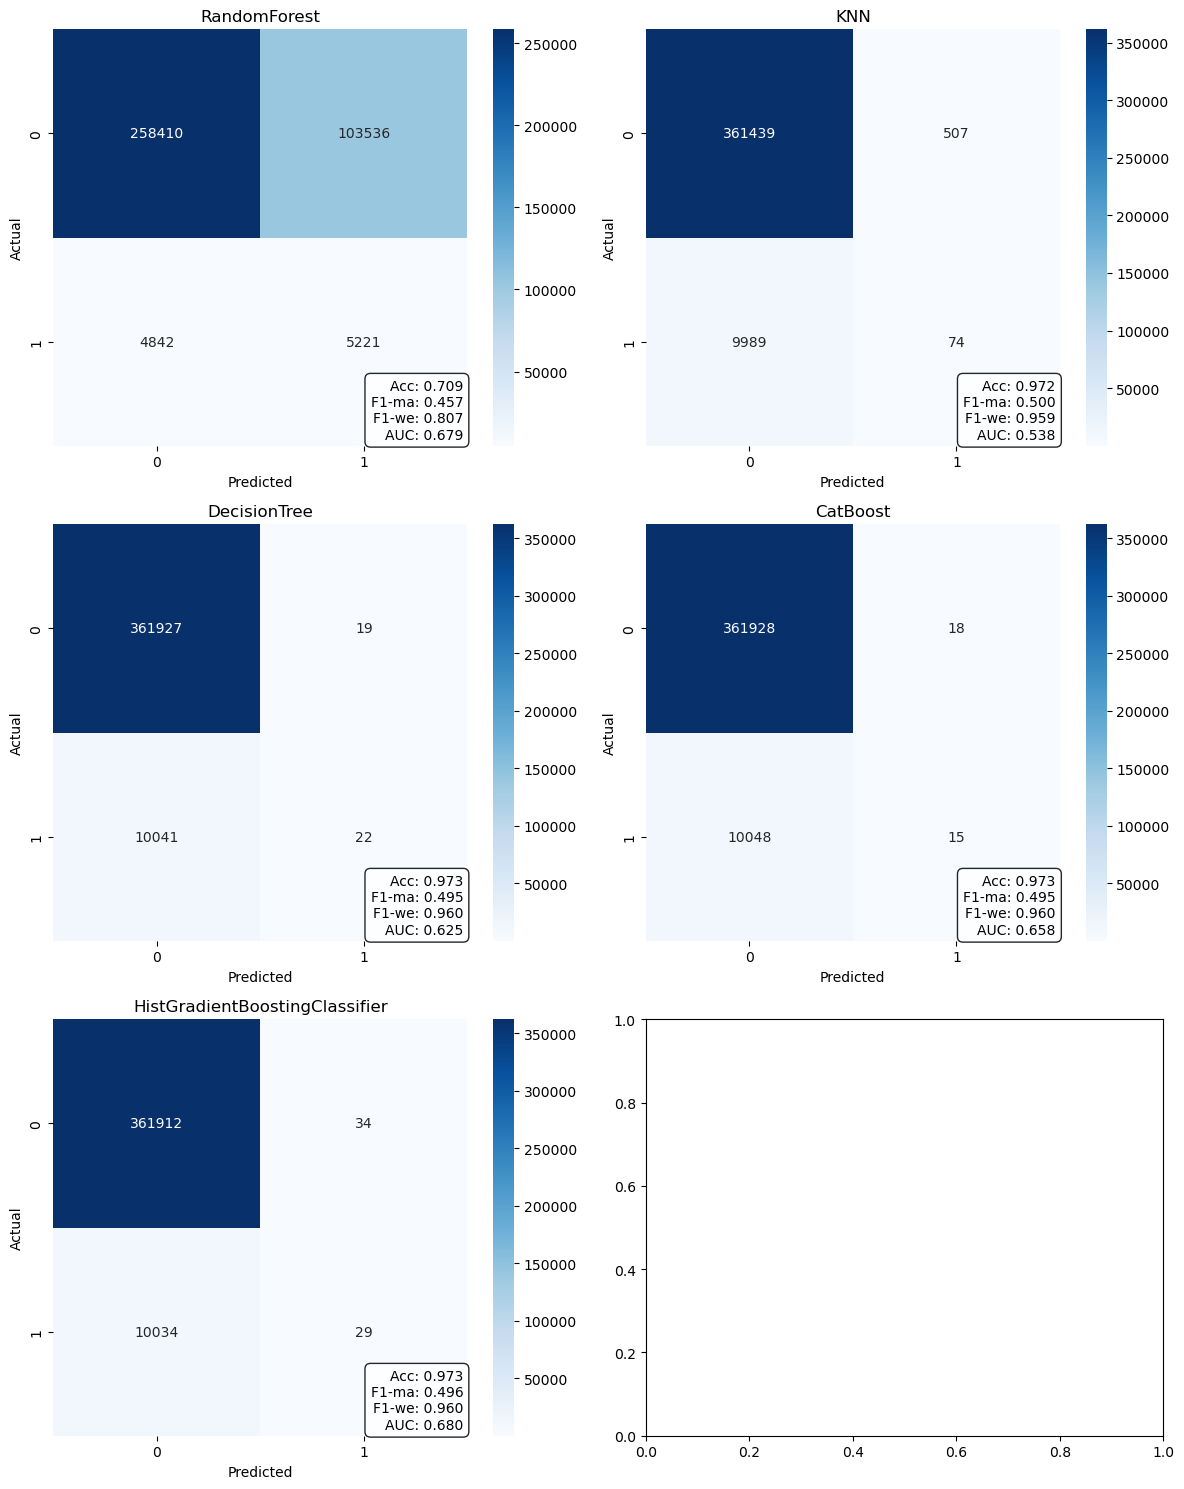

In [159]:
!pip install catboost
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Набор моделей
models = {
    "RandomForest": RandomForestClassifier(
        bootstrap=True, 
        max_depth=18, 
        max_features='log2',
        min_samples_leaf=10, 
        min_samples_split=20,
        n_estimators=600,
        class_weight='balanced',
        random_state=42, 
        n_jobs=-1  # n_jobs=-1 = все ядра
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1  # KNN тоже поддерживает n_jobs
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=5, random_state=42  # Увы, не поддерживает многопоточность
    ),
    "CatBoost": CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=100,
        thread_count=-1  # CatBoost использует thread_count для многопоточности
    ),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(
        l2_regularization=10.0, 
        learning_rate=0.023530526879850383, 
        max_bins=205, 
        max_iter=1000, 
        max_leaf_nodes=100,
        min_samples_leaf=40
    )
}
# Обучение и предсказание
predictions = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_val)
    predictions[name] = y_pred

all_labels = sorted(np.unique(np.concatenate([y_train, y_val])))

n_models = len(models)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)  # автоматически вычисляем количество строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, predictions.items()):
    # ----- матрица ошибок с фиксированным списком классов -----
    cm = confusion_matrix(y_val, y_pred, labels=all_labels)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        xticklabels=all_labels,
        yticklabels=all_labels
    )
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # ----- метрики -----
    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_weighted = f1_score(y_val, y_pred, average='weighted')

    # ROC AUC (если доступен predict_proba)
    model_fitted = models[name]  # получаем обученную модель
    if hasattr(model_fitted, "predict_proba"):
        y_proba = model_fitted.predict_proba(X_val)

        if y_proba.shape[1] == 2:
            auc = roc_auc_score(y_val, y_proba[:, 1])
        else:
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
    else:
        auc = float('nan')  # если predict_proba недоступен

    # Текст метрик
    metrics_text = (f"Acc: {acc:.3f}\n"
                    f"F1-ma: {f1_macro:.3f}\n"
                    f"F1-we: {f1_weighted:.3f}\n"
                    f"AUC: {auc:.3f}")


    ax.text(
        0.99, 0.01, metrics_text,
        transform=ax.transAxes,
        va='bottom', ha='right',
        fontsize=10, color='black',
        bbox=dict(boxstyle='round,pad=0.4',
                  facecolor='white',
                  edgecolor='black',
                  alpha=0.85)
    )

plt.tight_layout()
plt.show()

In [160]:
# ⬇︎ Устанавливать только один раз
!pip install scikit-optimize

# --- Импорты
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# --- 2) Pipeline: SMOTE + RandomForest
pipeline = Pipeline(steps=[
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1          # многопоточность
    ))
])

# --- 3) Пространство гиперпараметров для случайного леса
param_space = {
    'classifier__n_estimators'     : Integer(100, 600),
    'classifier__max_depth'        : Integer(3, 30),
    'classifier__max_features'     : Categorical(['sqrt', 'log2', None]),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf' : Integer(1, 10),
    'classifier__bootstrap'        : Categorical([True, False]),
    'classifier__class_weight'     : Categorical(['balanced', None]),
}

# --- 4) Байесовская оптимизация
opt = BayesSearchCV(
    estimator   = pipeline,
    search_spaces = param_space,
    scoring     = 'roc_auc',        # для бинарного случая
    cv          = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter      = 30,                         # число итераций поиска
    n_jobs      = -1,                         # параллельный запуск фолдов
    verbose     = 1,
    random_state= 42
)

# --- 5) Запуск оптимизации
opt.fit(X_sampled, y_sampled)

# --- 6) Лучшие параметры и ROC AUC
print("Best ROC AUC :", opt.best_score_)
print("Best Params :", opt.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\Roman\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Best ROC AUC : 0.6571325369741094
Best Params : OrderedDict({'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 9, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 600})


Accuracy: 0.6631586870210129
              precision    recall  f1-score   support

           0       0.98      0.67      0.79    361946
           1       0.04      0.57      0.08     10063

    accuracy                           0.66    372009
   macro avg       0.51      0.62      0.44    372009
weighted avg       0.96      0.66      0.77    372009



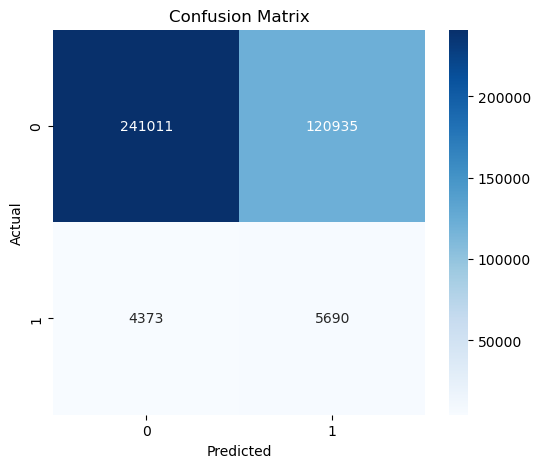

F1 macro: 0.4384646233230389
F1 weighted: 0.7744568263828346
ROC AUC: 0.672154948367619


In [161]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    max_depth=9,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=20,
    n_estimators=600,
    random_state=42,
    n_jobs=-1  # использовать все ядра CPU
)

model.fit(X_train_res, y_train_res)

# Предсказания на валидации
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()

print("F1 macro:", f1_score(y_val, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_val, y_pred, average='weighted'))

y_proba = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_proba[:, 1])
print("ROC AUC:", roc_auc)